In [98]:
import FinanceDataReader as fdr
import pandas as pd
import random

pd.set_option('display.max_columns', None)

### 국내 주식 종목코드와 층화표본데이터 합치기

In [133]:
# 국내 주식종목의 symbol(종목코드), market, name 가져오기
df_krx = fdr.StockListing('KRX').iloc[:,:3]
df_krx.columns = ['거래소코드','시장구분','회사명_krx']
df_krx = df_krx[df_krx['시장구분'].str.contains('KOSPI|KOSDAQ')]

# 상장폐지된 기업도 가져오기(KRX stock delisting symbol list : 상장폐지 종목 전체 리스트)
krx_delisting = fdr.StockListing('KRX-DELISTING').iloc[:,:3]
krx_delisting.columns = ['거래소코드','회사명_krx','시장구분']
krx_delisting = krx_delisting[['거래소코드','시장구분','회사명_krx']]
krx_delisting = krx_delisting[krx_delisting['시장구분'].str.contains('KOSPI|KOSDAQ')]

# 상장기업과 상폐기업 concat하기
krx_all = pd.concat([df_krx, krx_delisting],axis=0)


# 층화표본 할 데이터 불러오기
df = pd.read_csv('./데이터/국면별_데이터셋/feature_select_dataset1/dataset1_general_win+robust.csv', encoding='CP949')
df.drop(columns='Unnamed: 0', inplace=True)

# 거래소코드 6자리 채우기
df['거래소코드'] = df['거래소코드'].astype(str).str.zfill(6)

# 원본데이터프레임에 주식 종목코드 넣기
df_under = pd.merge(df, krx_all, on = '거래소코드', how='left')
df_under.drop('회사명_krx',axis=1,inplace=True)

# 컬럼 재정렬
df_under = df_under[['회사명', '거래소코드', '회계년도', '상장일', '상장폐지일_x', '부실기업1', '부실기업2', '부실기업','시장구분',
       '업종', '경기민감도', '총자본증가율', '자기자본증가율', '매출액증가율', '종업원수증가율', '정상영업손익증가율',
       '총자본정상영업이익률', '금융비용부담률', '1주당순이익', '유동비율', '당좌비율', '부채비율',
       'CASH FLOW 대 부채비율', 'CASH FLOW 대 매출액비율', '총자본투자효율', '부가가치율',
       '종업원1인당부가가치율_계산', '자기자본회전률', '타인자본회전률']]

# 시장구분상 nan으로 뜨는 코넥스 기업이 아주 조금 있어서 삭제함
df_under = df_under.dropna(subset = ['시장구분'])

# 데이터 모양
print(df_under.shape, '\n')

(12737, 29) 



In [134]:
df_under[df_under['시장구분'].isna() == True]

Empty DataFrame
Columns: [회사명, 거래소코드, 회계년도, 상장일, 상장폐지일_x, 부실기업1, 부실기업2, 부실기업, 시장구분, 업종, 경기민감도, 총자본증가율, 자기자본증가율, 매출액증가율, 종업원수증가율, 정상영업손익증가율, 총자본정상영업이익률, 금융비용부담률, 1주당순이익, 유동비율, 당좌비율, 부채비율, CASH FLOW 대 부채비율, CASH FLOW 대 매출액비율, 총자본투자효율, 부가가치율, 종업원1인당부가가치율_계산, 자기자본회전률, 타인자본회전률]
Index: []

In [16]:
# # 부실, 정상기업 비율 확인
# # 한계기업 합계
# df_broke = df_under[df_under['부실기업']==1]
# df_norm = df_under[df_under['부실기업']==0]
# print('부실기업 수  : ', df_broke['회사명'].nunique())
# print('정상기업 수 : ', df_norm['회사명'].nunique())

# # 업종별 한계기업 합계
# df_broke_sens = df_under[(df_under['부실기업']==1) & (df_under['경기민감도']==1)]
# df_broke_no = df_under[(df_under['부실기업']==1) & (df_under['경기민감도']==0)]
# df_norm_sens = df_under[(df_under['부실기업']==0) & (df_under['경기민감도'] == 1)]
# df_norm_no = df_under[(df_under['부실기업']==0) & (df_under['경기민감도'] == 0)]
# print('경기민감 부실기업 수 : ', df_broke_sens['회사명'].nunique())
# print('경기안민감 부실기업 수 : ', df_broke_no['회사명'].nunique())
# print('경기민감 정상기업 수 : ', df_norm_sens['회사명'].nunique())
# print('경기안민감 정상기업 수 : ', df_norm_no['회사명'].nunique())
  

### 언더샘플링을 위한 데이터 계층화

In [135]:
# 시장과 경기민감에 따른 계층 비율 찾기
df_under2 = df_under.copy()

# 부실, 정상기업 비율 확인
df_broke = df_under2[df_under2['부실기업']==1]
df_broke.reset_index(drop=True,inplace=True)

df_norm = df_under2[df_under2['부실기업']==0]
df_norm.reset_index(drop=True,inplace=True)

print('부실기업 수  : ', df_broke['회사명'].nunique())
print('정상기업 수 : ', df_norm['회사명'].nunique())

# 계층별 부실기업 비율 확인
df_broke_sens_kospi = df_broke[(df_broke['시장구분']=='KOSPI') & (df_broke['경기민감도']==1)]
df_broke_no_kospi = df_broke[(df_broke['시장구분']=='KOSPI') & (df_broke['경기민감도']==0)]

df_broke_sens_kosdaq = df_broke[(df_broke['시장구분']=='KOSDAQ') & (df_broke['경기민감도'] == 1)]
df_broke_no_kosdaq = df_broke[(df_broke['시장구분']=='KOSDAQ') & (df_broke['경기민감도'] == 0)]

print('\n계층1 - 코스피 민감 부실기업 수 : ', df_broke_sens_kospi['회사명'].nunique())
print('계층2 - 코스피 안민감 부실기업 수 : ', df_broke_no_kospi['회사명'].nunique())
print('계층3 - 코스닥 민감 부실기업 수 : ', df_broke_sens_kosdaq['회사명'].nunique())
print('계층4 - 코스닥 안민감 부실기업 수 : ', df_broke_no_kosdaq['회사명'].nunique())

부실기업 수  :  754
정상기업 수 :  1776

계층1 - 코스피 민감 부실기업 수 :  193
계층2 - 코스피 안민감 부실기업 수 :  41
계층3 - 코스닥 민감 부실기업 수 :  423
계층4 - 코스닥 안민감 부실기업 수 :  97


In [136]:
# 권역변수를 만들어서 부실기업 broke_KOSPI, broke_KOSDAQ 데이터프레임 생성
for i in df_broke['시장구분'].unique():
    globals()['broke_{}'.format(i)] = df_broke[df_broke['시장구분']==i]
    globals()['broke_{}'.format(i)].reset_index(drop=True,inplace=True)

# 권역변수를 만들어서 정상기업 norm_KOSPI, norm_KOSDAQ 데이터프레임 생성
for i in df_norm['시장구분'].unique():
    globals()['norm_{}'.format(i)] = df_norm[df_norm['시장구분']==i]
    globals()['norm_{}'.format(i)].reset_index(drop=True,inplace=True)


# 데이터프레임 정의
broke_kospi = broke_KOSPI   # 부실기업 코스피
broke_kosdaq = broke_KOSDAQ # 부실기업 코스닥

norm_kospi = norm_KOSPI     # 정상기업 코스피
norm_kosdaq = norm_KOSDAQ   # 정상기업 코스닥


# 부실기업  코스피 경기민감도
broke_kospi_1 = broke_kospi[broke_kospi['경기민감도']==1].reset_index(drop=True)
broke_kospi_0 = broke_kospi[broke_kospi['경기민감도']==0].reset_index(drop=True)

# 부실기업 코스닥 경기민감도
broke_kosdaq_1 = broke_kosdaq[broke_kosdaq['경기민감도']==1].reset_index(drop=True)
broke_kosdaq_0 = broke_kosdaq[broke_kosdaq['경기민감도']==0].reset_index(drop=True)


# 정상기업  코스피 경기민감도
norm_kospi_1 = norm_kospi[norm_kospi['경기민감도']==1].reset_index(drop=True)
norm_kospi_0 = norm_kospi[norm_kospi['경기민감도']==0].reset_index(drop=True)

# 정상기업 코스닥 경기민감도
norm_kosdaq_1 = norm_kosdaq[norm_kosdaq['경기민감도']==1].reset_index(drop=True)
norm_kosdaq_0 = norm_kosdaq[norm_kosdaq['경기민감도']==0].reset_index(drop=True)

    부실기업 수  :  754  
    정상기업 수 :  1776 
       
    계층1 - 코스피 민감 부실기업 수 :  193  
    계층2 - 코스피 안민감 부실기업 수 :  41  
    계층3 - 코스닥 민감 부실기업 수 :  423  
    계층4 - 코스닥 안민감 부실기업 수 :  97

#### 방법 1
- 정상기업의 인덱스를 묶어놓고 랜덤으로 n개를 뽑음
- 그리고 나서 for문으로 각 기업의 하나의 행만 추출

In [143]:
# 정상기업 코스피 + 민감 회사명 리스트
norm_kospi_1_list = norm_kospi_1['회사명'].unique()

# 정상기업 코스피 + 민감 회사명 인덱스 묶음
norm_kospi_1_index = []
for i in norm_kospi_1_list:
    norm_kospi_1_index.append(norm_kospi_1[norm_kospi_1['회사명']==i].index)

# 회사별 인덱스 랜덤샘플링
random_norm_kospi_1 = random.sample(norm_kospi_1_index, 193)
random_norm_kospi_1

# print('코스피 민감 정상기업 인덱스 묶음 수 :', len(random_norm_kospi_1))

[Int64Index([2882], dtype='int64'),
 Int64Index([2380, 2381, 2382, 2383, 2384], dtype='int64'),
 Int64Index([3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014], dtype='int64'),
 Int64Index([374, 375, 376, 377, 378, 379], dtype='int64'),
 Int64Index([3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034], dtype='int64'),
 Int64Index([564], dtype='int64'),
 Int64Index([855, 856, 857, 858, 859, 860, 861, 862, 863, 864], dtype='int64'),
 Int64Index([2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544], dtype='int64'),
 Int64Index([2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720], dtype='int64'),
 Int64Index([2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804], dtype='int64'),
 Int64Index([11, 12, 13, 14, 15, 16, 17, 18], dtype='int64'),
 Int64Index([1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572], dtype='int64'),
 Int64Index([1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348], dtype='int64'),
 Int64Index([3824, 3825, 3826, 3827, 3828, 3829, 

#### 방법 2
- 회사명이랑 인덱스를 추출해서 리스트를 만들고(인덱스 추출 할 때 회사명 겹쳐도 상관 없음)
- 그 리스트 안에서 n개를 랜덤 추출함(여기서 랜덤 추출할 땐 회사명 겹치면 안됨)
- 랜덤 추출된 리스트에 맞는 인덱스 행 붙여넣기

In [139]:
norm_kospi_1

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
0      (주)HJ중공업  097230  201112  200708      NaN      0      0     0  KOSPI   
1      (주)MH에탄올  023150  201112  199612      NaN      0      0     0  KOSPI   
2      (주)MH에탄올  023150  201212  199612      NaN      0      0     0  KOSPI   
3      (주)MH에탄올  023150  201312  199612      NaN      0      0     0  KOSPI   
4      (주)MH에탄올  023150  201412  199612      NaN      0      0     0  KOSPI   
...         ...     ...     ...     ...      ...    ...    ...   ...    ...   
3976  효성첨단소재(주)  298050  202012  201807      NaN      0      0     0  KOSPI   
3977   효성티앤씨(주)  298020  201912  201807      NaN      0      0     0  KOSPI   
3978   효성티앤씨(주)  298020  202012  201807      NaN      0      0     0  KOSPI   
3979    효성화학(주)  298000  201912  201807      NaN      0      0     0  KOSPI   
3980    효성화학(주)  298000  202012  201807      NaN      0      0     0  KOSPI   

       업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0     건설업      1  -7.119470  -7.519747  -9.364473   -19.81  -50.600260   
1     제조업      1   4.630770   0.229278 -17.196532    -3.77  -69.824215   
2     제조업      1   0.133348  -7.005544  33.455315     1.96  594.671706   
3     제조업      1  -3.488372  15.643993   4.068573    -1.92  -44.792949   
4     제조업      1 -22.363090  15.044305 -21.247797     3.92  190.551612   
...   ...    ...        ...        ...        ...      ...         ...   
3976  제조업      1  -6.104265  -5.991533 -21.580753    -3.66  -78.393745   
3977  제조업      1   2.722732  19.727281  78.118241     0.00  158.222909   
3978  제조업      1 -12.411317  22.712275 -13.730702    -0.59  -17.451703   
3979  제조업      1  24.815804  23.815008  62.295452     0.00  136.768721   
3980  제조업      1  17.147841 -11.514040   0.260395     1.55  -60.407684   

      총자본정상영업이익률  금융비용부담률        1주당순이익    유동비율   당좌비율    부채비율  \
0           1.48     5.30  -2007.104595   96.33  81.81  276.93   
1           0.45     5.30   -622.473143   58.36  45.92  214.54   
2           4.06     5.30     41.052714   61.27  36.07  238.69   
3           2.28     5.07   1004.033429   57.37  40.78  182.66   
4           8.13     2.46    -27.538427   90.87  68.77   62.03   
...          ...      ...           ...     ...    ...     ...   
3976        1.39     1.95   1520.171439   59.64  39.02  388.92   
3977       10.15     1.23  16360.357690   70.87  45.60  388.92   
3978        8.81     0.96  16360.357690   75.56  54.47  294.79   
3979        8.28     2.00  16360.357690  103.42  73.85  353.81   
3980        2.72     2.38  -2238.020276   69.44  46.62  388.92   

      CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0                -0.99              -1.77     7.02  17.09      130.711670   
1                 2.62               5.35     6.51  19.52      238.355882   
2                -2.50              -3.95    11.43  25.71      220.690961   
3                 0.72               0.97    10.06  20.98      -75.622218   
4                17.21              11.51    13.21  23.06      208.123208   
...                ...                ...      ...    ...             ...   
3976             11.01               9.17    21.88  21.72      120.491830   
3977              8.81               3.89    22.95  12.37      137.467586   
3978             21.68               8.86    25.36  13.88      149.191073   
3979              7.46               6.62    19.37  22.06      344.557468   
3980              8.23               9.12    13.73  18.26      280.374108   

       자기자본회전률  타인자본회전률  
0     1.548867     0.58  
1     1.049636     0.58  
2     1.451642     0.64  
3     1.453884     0.70  
4     0.992839     0.84  
...        ...      ...  
3976  6.550720     1.16  
3977  6.089227     2.26  
3978  6.550720     2.17  
3979  6.550720     1.25  
3980  3.986006     1.00  

[3981 rows x 29 columns]

In [138]:
norm_kospi_1['회사명']

0        (주)HJ중공업
1        (주)MH에탄올
2        (주)MH에탄올
3        (주)MH에탄올
4        (주)MH에탄올
          ...    
3976    효성첨단소재(주)
3977     효성티앤씨(주)
3978     효성티앤씨(주)
3979      효성화학(주)
3980      효성화학(주)
Name: 회사명, Length: 3981, dtype: object

In [ ]:
a = []    # 빈 리스트 생성
 
for i in range(len(norm_kospi_1['회사명'])):
    line = []              # 안쪽 리스트로 사용할 빈 리스트 생성
    for j in range(2):
        line.append(0)     # 안쪽 리스트에 0 추가
    a.append(line)  

In [141]:
a = []

for index, value in enumerate(norm_kospi_1['회사명']):
    list = []
    for j in range

    print(index, value)

0 (주)HJ중공업
1 (주)MH에탄올
2 (주)MH에탄올
3 (주)MH에탄올
4 (주)MH에탄올
5 (주)MH에탄올
6 (주)MH에탄올
7 (주)MH에탄올
8 (주)MH에탄올
9 (주)MH에탄올
10 (주)MH에탄올
11 (주)SH에너지화학
12 (주)SH에너지화학
13 (주)SH에너지화학
14 (주)SH에너지화학
15 (주)SH에너지화학
16 (주)SH에너지화학
17 (주)SH에너지화학
18 (주)SH에너지화학
19 (주)SIMPAC
20 (주)SIMPAC
21 (주)SIMPAC
22 (주)SIMPAC
23 (주)SIMPAC
24 (주)SIMPAC
25 (주)SIMPAC
26 (주)SIMPAC
27 (주)SIMPAC
28 (주)SIMPAC
29 (주)SNT에너지
30 (주)SNT에너지
31 (주)SNT에너지
32 (주)SNT에너지
33 (주)SNT에너지
34 (주)SNT에너지
35 (주)STX
36 (주)STX
37 (주)TCC스틸
38 (주)TCC스틸
39 (주)경농
40 (주)경농
41 (주)경농
42 (주)경농
43 (주)경농
44 (주)경농
45 (주)경농
46 (주)경농
47 (주)경농
48 (주)경농
49 (주)경동나비엔
50 (주)경동나비엔
51 (주)경동나비엔
52 (주)경동나비엔
53 (주)경동나비엔
54 (주)경동나비엔
55 (주)경동나비엔
56 (주)경동나비엔
57 (주)경동나비엔
58 (주)경동나비엔
59 (주)경방
60 (주)경방
61 (주)경방
62 (주)경방
63 (주)경방
64 (주)경방
65 (주)경방
66 (주)경방
67 (주)경방
68 (주)경방
69 (주)경보제약
70 (주)경보제약
71 (주)경보제약
72 (주)경보제약
73 (주)경보제약
74 (주)경보제약
75 (주)경인양행
76 (주)경인양행
77 (주)경인양행
78 (주)경인양행
79 (주)경인양행
80 (주)경인양행
81 (주)경인양행
82 (주)경인양행
83 (주)경인양행
84 (주)경인양행
85 (주)광명전기
86 (주)광명전기
87 (주)광명전기
88 (주

In [130]:
norm_kospi2_1

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
0      (주)HJ중공업  097230  201112  200708      NaN      0      0     0  KOSPI   
1      (주)MH에탄올  023150  201112  199612      NaN      0      0     0  KOSPI   
2      (주)MH에탄올  023150  201212  199612      NaN      0      0     0  KOSPI   
3      (주)MH에탄올  023150  201312  199612      NaN      0      0     0  KOSPI   
4      (주)MH에탄올  023150  201412  199612      NaN      0      0     0  KOSPI   
...         ...     ...     ...     ...      ...    ...    ...   ...    ...   
5019  효성첨단소재(주)  298050  202012  201807      NaN      0      0     0  KOSPI   
5020   효성티앤씨(주)  298020  201912  201807      NaN      0      0     0  KOSPI   
5021   효성티앤씨(주)  298020  202012  201807      NaN      0      0     0  KOSPI   
5022    효성화학(주)  298000  201912  201807      NaN      0      0     0  KOSPI   
5023    효성화학(주)  298000  202012  201807      NaN      0      0     0  KOSPI   

       업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0     건설업      1  -7.119470  -7.519747  -9.364473   -19.81  -50.600260   
1     제조업      1   4.630770   0.229278 -17.196532    -3.77  -69.824215   
2     제조업      1   0.133348  -7.005544  33.455315     1.96  594.671706   
3     제조업      1  -3.488372  15.643993   4.068573    -1.92  -44.792949   
4     제조업      1 -22.363090  15.044305 -21.247797     3.92  190.551612   
...   ...    ...        ...        ...        ...      ...         ...   
5019  제조업      1  -6.104265  -5.991533 -21.580753    -3.66  -78.393745   
5020  제조업      1   2.722732  19.727281  78.118241     0.00  158.222909   
5021  제조업      1 -12.411317  22.712275 -13.730702    -0.59  -17.451703   
5022  제조업      1  24.815804  23.815008  62.295452     0.00  136.768721   
5023  제조업      1  17.147841 -11.514040   0.260395     1.55  -60.407684   

      총자본정상영업이익률  금융비용부담률        1주당순이익    유동비율   당좌비율    부채비율  \
0           1.48     5.30  -2007.104595   96.33  81.81  276.93   
1           0.45     5.30   -622.473143   58.36  45.92  214.54   
2           4.06     5.30     41.052714   61.27  36.07  238.69   
3           2.28     5.07   1004.033429   57.37  40.78  182.66   
4           8.13     2.46    -27.538427   90.87  68.77   62.03   
...          ...      ...           ...     ...    ...     ...   
5019        1.39     1.95   1520.171439   59.64  39.02  388.92   
5020       10.15     1.23  16360.357690   70.87  45.60  388.92   
5021        8.81     0.96  16360.357690   75.56  54.47  294.79   
5022        8.28     2.00  16360.357690  103.42  73.85  353.81   
5023        2.72     2.38  -2238.020276   69.44  46.62  388.92   

      CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0                -0.99              -1.77     7.02  17.09      130.711670   
1                 2.62               5.35     6.51  19.52      238.355882   
2                -2.50              -3.95    11.43  25.71      220.690961   
3                 0.72               0.97    10.06  20.98      -75.622218   
4                17.21              11.51    13.21  23.06      208.123208   
...                ...                ...      ...    ...             ...   
5019             11.01               9.17    21.88  21.72      120.491830   
5020              8.81               3.89    22.95  12.37      137.467586   
5021             21.68               8.86    25.36  13.88      149.191073   
5022              7.46               6.62    19.37  22.06      344.557468   
5023              8.23               9.12    13.73  18.26      280.374108   

       자기자본회전률  타인자본회전률  
0     1.548867     0.58  
1     1.049636     0.58  
2     1.451642     0.64  
3     1.453884     0.70  
4     0.992839     0.84  
...        ...      ...  
5019  6.550720     1.16  
5020  6.089227     2.26  
5021  6.550720     2.17  
5022  6.550720     1.25  
5023  3.986006     1.00  

[3981 rows x 29 columns]

In [132]:
# 회사명과 인덱스
norm_kospi2_1['회사명']

0        (주)HJ중공업
1        (주)MH에탄올
2        (주)MH에탄올
3        (주)MH에탄올
4        (주)MH에탄올
          ...    
5019    효성첨단소재(주)
5020     효성티앤씨(주)
5021     효성티앤씨(주)
5022      효성화학(주)
5023      효성화학(주)
Name: 회사명, Length: 3981, dtype: object

In [131]:
# 컬럼별 인덱스 번호 확인
for i, col in enumerate(norm_kospi_1['회사명']):
    print(i, col)

0 (주)HJ중공업
1 (주)MH에탄올
2 (주)MH에탄올
3 (주)MH에탄올
4 (주)MH에탄올
5 (주)MH에탄올
6 (주)MH에탄올
7 (주)MH에탄올
8 (주)MH에탄올
9 (주)MH에탄올
10 (주)MH에탄올
11 (주)SH에너지화학
12 (주)SH에너지화학
13 (주)SH에너지화학
14 (주)SH에너지화학
15 (주)SH에너지화학
16 (주)SH에너지화학
17 (주)SH에너지화학
18 (주)SH에너지화학
19 (주)SIMPAC
20 (주)SIMPAC
21 (주)SIMPAC
22 (주)SIMPAC
23 (주)SIMPAC
24 (주)SIMPAC
25 (주)SIMPAC
26 (주)SIMPAC
27 (주)SIMPAC
28 (주)SIMPAC
29 (주)SNT에너지
30 (주)SNT에너지
31 (주)SNT에너지
32 (주)SNT에너지
33 (주)SNT에너지
34 (주)SNT에너지
35 (주)STX
36 (주)STX
37 (주)TCC스틸
38 (주)TCC스틸
39 (주)경농
40 (주)경농
41 (주)경농
42 (주)경농
43 (주)경농
44 (주)경농
45 (주)경농
46 (주)경농
47 (주)경농
48 (주)경농
49 (주)경동나비엔
50 (주)경동나비엔
51 (주)경동나비엔
52 (주)경동나비엔
53 (주)경동나비엔
54 (주)경동나비엔
55 (주)경동나비엔
56 (주)경동나비엔
57 (주)경동나비엔
58 (주)경동나비엔
59 (주)경방
60 (주)경방
61 (주)경방
62 (주)경방
63 (주)경방
64 (주)경방
65 (주)경방
66 (주)경방
67 (주)경방
68 (주)경방
69 (주)경보제약
70 (주)경보제약
71 (주)경보제약
72 (주)경보제약
73 (주)경보제약
74 (주)경보제약
75 (주)경인양행
76 (주)경인양행
77 (주)경인양행
78 (주)경인양행
79 (주)경인양행
80 (주)경인양행
81 (주)경인양행
82 (주)경인양행
83 (주)경인양행
84 (주)경인양행
85 (주)광명전기
86 (주)광명전기
87 (주)광명전기
88 (주

In [48]:
a=norm_kospi_1['회사명'].unique().tolist()

random.sample(a, 193)

['(주)코아스',
 '영화금속(주)',
 '(주)한솔케미칼',
 '한국쉘석유(주)',
 '(주)테이팩스',
 '선도전기(주)',
 '동아에스티(주)',
 '(주)한국화장품제조',
 '덕양산업(주)',
 '케이알모터스(주)',
 '효성화학(주)',
 '(주)대유플러스',
 '(주)지에스리테일',
 '에쓰-오일(주)',
 '(주)위스컴',
 '미원상사(주)',
 '고려개발(주)',
 '신세계건설(주)',
 '율촌화학(주)',
 '삼화전기(주)',
 '핸즈코퍼레이션(주)',
 '영풍제지(주)',
 '태광산업(주)',
 '(주)엔케이',
 '현대제철(주)',
 '세원이앤씨(주)',
 '한솔피엔에스(주)',
 '(주)호텔신라',
 '(주)에이엔피',
 '(주)신화다이나믹스',
 '(주)서연이화',
 '현대건설기계(주)',
 '성신양회(주)',
 '동원시스템즈(주)',
 '삼화왕관(주)',
 '동일고무벨트(주)',
 '애경케미칼(주)',
 '한국유리공업(주)',
 '진양산업(주)',
 '(주)대웅제약',
 '웅진에너지(주)',
 '케이피엑스홀딩스(주)',
 '동아타이어공업(주)',
 '동일산업(주)',
 '고려산업(주)',
 '(주)SH에너지화학',
 '한솔제지(주)',
 '(주)에스와이코퍼레이션',
 '고려제강(주)',
 '(주)한솔홈데코',
 '(주)대호에이엘',
 '(주)경보제약',
 '(주)엘지생활건강',
 '대우조선해양(주)',
 '(주)화승엔터프라이즈',
 '(주)한독',
 '(주)화승코퍼레이션',
 '(주)신세계인터내셔날',
 '(주)케이에이치필룩스',
 '삼영전자공업(주)',
 '한화화인케미칼(주)',
 '(주)삼원강재',
 '현대자동차(주)',
 '(주)현대백화점',
 '에스케이네트웍스(주)',
 '(주)포스코케미칼',
 '에이치에스디엔진(주)',
 '(주)에스제이엠',
 '대상(주)',
 '삼아알미늄(주)',
 '무림피앤피(주)',
 '(주)모토닉',
 '신일전자(주)',
 '동양피스톤(주)',
 '(주)무학',
 '(주)신일건업',
 '(주)현대홈쇼

In [45]:
### 컬럼별 인덱스 번호 확인
for i, col in enumerate(norm_kospi_1['회사명'].unique()):
    print(i, col)

0 (주)HJ중공업
1 (주)MH에탄올
2 (주)SH에너지화학
3 (주)SIMPAC
4 (주)SNT에너지
5 (주)STX
6 (주)TCC스틸
7 (주)경농
8 (주)경동나비엔
9 (주)경방
10 (주)경보제약
11 (주)경인양행
12 (주)광명전기
13 (주)광주신세계
14 (주)국동
15 (주)금양
16 (주)금호에이치티
17 (주)남선알미늄
18 (주)남성
19 (주)넥센
20 (주)넥솔론
21 (주)노루페인트
22 (주)녹십자
23 (주)농심
24 (주)다이나믹디자인
25 (주)대동
26 (주)대우건설
27 (주)대웅
28 (주)대웅제약
29 (주)대유에이텍
30 (주)대유플러스
31 (주)대창
32 (주)대현
33 (주)대호에이엘
34 (주)덕성
35 (주)덴티움
36 (주)동남합성
37 (주)동방아그로
38 (주)동서
39 (주)동아지질
40 (주)동원에프앤비
41 (주)두올
42 (주)디아이
43 (주)디아이씨
44 (주)디알비동일
45 (주)디엔오토모티브
46 (주)락앤락
47 (주)로케트전기
48 (주)마니커
49 (주)만도
50 (주)메타랩스
51 (주)모나리자
52 (주)모나미
53 (주)모토닉
54 (주)무학
55 (주)백산
56 (주)벽산
57 (주)보락
58 (주)보령
59 (주)비비안
60 (주)비와이씨
61 (주)비지에프리테일
62 (주)빙그레
63 (주)사조대림
64 (주)사조오양
65 (주)사조해표
66 (주)삼양사
67 (주)삼양엔텍
68 (주)삼양제넥스
69 (주)삼양패키징
70 (주)삼원강재
71 (주)삼익악기
72 (주)삼일씨엔에스
73 (주)서연이화
74 (주)서원
75 (주)서흥
76 (주)선앤엘
77 (주)선진
78 (주)성안
79 (주)세아베스틸지주
80 (주)세아제강
81 (주)세아특수강
82 (주)세아홀딩스
83 (주)세우글로벌
84 (주)세이브존아이앤씨
85 (주)세진중공업
86 (주)센트랄모텍
87 (주)셀트리온
88 (주)수산중공업
89 (주)시디즈
90 (주)신도리코
91 (주)신세계
92 (주)신세계인터

In [174]:
# 부실기업 코스피 경기민감도 기준으로 회사 분포 확인
broke_KOSPI.groupby('경기민감도').count()['회사명']

경기민감도
0     41
1    193
Name: 회사명, dtype: int64

In [175]:
# 3) label 빈도수 체크
for i in df_broke['시장구분'].unique():
    globals()['broke_{}_count'.format(i)] = globals()['broke_{}'.format(i)].groupby('경기민감도').count()
    globals()['broke_{}_val'.format(i)] = globals()['broke_{}'.format(i)].groupby('경기민감도')['거래소코드'].count().tolist()
    globals()['broke_{}_li'.format(i)] = globals()['broke_{}_count'.format(i)].index.tolist()

In [176]:
broke_KOSPI_count

회사명  거래소코드  회계년도  상장일  상장폐지일_x  부실기업1  부실기업2  부실기업  시장구분   업종  총자본증가율  \
경기민감도                                                                          
0       41     41    41   41        2     41     41    41    41   41      41   
1      193    193   193  193       24    193    193   193   193  193     193   

       자기자본증가율  매출액증가율  종업원수증가율  정상영업손익증가율  총자본정상영업이익률  금융비용부담률  1주당순이익  유동비율  \
경기민감도                                                                           
0           41      41       41         41          41       41      41    41   
1          193     193      193        193         193      193     193   193   

       당좌비율  부채비율  CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  \
경기민감도                                                                    
0        41    41                41                 41       41     41   
1       193   193               193                193      193    193   

       종업원1인당부가가치율_계산  자기자본회전률  타인자본회전률  
경기민감도                                    
0                  41       41       41  
1                 193      193      193

In [130]:
# 부실기업 코스피 분포 확인
broke_KOSPI_val

[41, 193]

In [131]:
broke_KOSPI_li

[0, 1]

In [132]:
# 4) 산업분류에 따라 랜덤 뽑고 재 df화하기
df_sample = pd.DataFrame()
for i in df_broke['시장구분'].unique():
    for j,k in zip(globals()['broke_{}_li'.format(i)],globals()['broke_{}_val'.format(i)]):
        try:
            df_sample_1 = globals()['norm_{}'.format(i)].loc[globals()['norm_{}'.format(i)]['경기민감도']==j].sample(n=k)
            df_sample_1 = df_sample_1.reset_index(drop=True)
            df_sample = pd.concat([df_sample,df_sample_1])
            df_sample.reset_index(drop=True,inplace=True)
        except:
            pass

In [133]:
norm_KOSDAQ

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업    시장구분  \
0     (주)CMG제약  058820  201112  200108      NaN      0      0     0  KOSDAQ   
1     (주)CMG제약  058820  201212  200108      NaN      0      0     0  KOSDAQ   
2     (주)CMG제약  058820  201312  200108      NaN      0      0     0  KOSDAQ   
3     (주)CMG제약  058820  201412  200108      NaN      0      0     0  KOSDAQ   
4     (주)CMG제약  058820  201512  200108      NaN      0      0     0  KOSDAQ   
...        ...     ...     ...     ...      ...    ...    ...   ...     ...   
6945   흥구석유(주)  024060  201612  199412      NaN      0      0     0  KOSDAQ   
6946   흥구석유(주)  024060  201712  199412      NaN      0      0     0  KOSDAQ   
6947   흥구석유(주)  024060  201812  199412      NaN      0      0     0  KOSDAQ   
6948   흥구석유(주)  024060  201912  199412      NaN      0      0     0  KOSDAQ   
6949   흥구석유(주)  024060  202012  199412      NaN      0      0     0  KOSDAQ   

            업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0          제조업      1  13.166482   5.219839  56.396905     4.65  594.671706   
1          제조업      1  78.275781  75.170505  -8.429134    -0.74 -432.398636   
2          제조업      1  -2.093352  55.100407  25.510008     1.49  594.671706   
3          제조업      1   3.855597   0.010946  11.520576    20.59  -44.098325   
4          제조업      1  -2.644307  -4.480893  18.851969    -4.88 -432.398636   
...        ...    ...        ...        ...        ...      ...         ...   
6945  도매 및 소매업      1   1.387285   1.392840  -7.264247    -3.03  108.431661   
6946  도매 및 소매업      1   0.979181   0.833881   8.117096    -3.13  -22.027770   
6947  도매 및 소매업      1  -5.889568   0.986153   6.874950    -9.68   45.369913   
6948  도매 및 소매업      1  11.243737   9.311157  -9.349453    -5.95  -54.160884   
6949  도매 및 소매업      1   0.071537   3.375172 -23.777328   -13.92 -198.608923   

      총자본정상영업이익률  금융비용부담률      1주당순이익     유동비율    당좌비율   부채비율  \
0           2.37     0.80  -34.519834   200.97  165.03  51.41   
1          -9.96     2.53 -100.872314   693.49  649.98  80.77   
2           1.40     1.65    3.419043   694.71  610.74  14.11   
3           0.78    -0.65    1.824365   324.58  268.23  18.50   
4          -4.49    -0.11  -41.338674   296.85  235.21  20.78   
...          ...      ...         ...      ...     ...    ...   
6945        1.23     0.02  145.175533   411.65  341.54  14.40   
6946        0.94     0.07  137.645400   177.50  146.69  14.56   
6947        1.41    -0.01  157.985933   329.17  290.09   8.48   
6948        0.63    -0.12  552.857733   485.39  422.76   8.65   
6949       -0.59    -0.11  319.424733  1062.09  940.60   8.48   

      CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0               -19.54             -13.66    12.72  19.56       27.179630   
1                -8.10             -12.71     0.47   1.66       -0.657015   
2               -19.54             -13.51    12.51  34.29       51.118235   
3               -17.73              -7.06    12.16  31.04       43.079512   
4                16.12               5.80     7.63  15.96       27.671795   
...                ...                ...      ...    ...             ...   
6945             28.21               1.95     8.84   4.86       72.848750   
6946             13.16               0.86     8.54   4.39       73.406344   
6947             69.29               1.99     9.80   4.44       87.780000   
6948             43.35               1.92    18.02  10.00      190.794177   
6949             29.75               1.07    12.27   8.94      151.056912   

       자기자본회전률  타인자본회전률  
0     0.984333     2.01  
1     0.655130     0.93  
2     0.506332     1.26  
3     0.464339     2.85  
4     0.564493     2.88  
...        ...      ...  
6945  2.308270     8.17  
6946  2.093682     8.17  
6947  2.238746     8.17  
6948  2.371074     8.17  
6949  2.043748     8.17  

[6950 rows x 29 columns]

In [134]:
df_broke.groupby('시장구분').count()

회사명  거래소코드  회계년도  상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   업종  경기민감도  \
시장구분                                                                     
KOSDAQ  523    523   523  523       73    523    523   523  523    523   
KOSPI   234    234   234  234       26    234    234   234  234    234   

        총자본증가율  자기자본증가율  매출액증가율  종업원수증가율  정상영업손익증가율  총자본정상영업이익률  금융비용부담률  \
시장구분                                                                       
KOSDAQ     523      523     523      523        523         523      523   
KOSPI      234      234     234      234        234         234      234   

        1주당순이익  유동비율  당좌비율  부채비율  CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  \
시장구분                                                                    
KOSDAQ     523   523   523   523               523                523   
KOSPI      234   234   234   234               234                234   

        총자본투자효율  부가가치율  종업원1인당부가가치율_계산  자기자본회전률  타인자본회전률  
시장구분                                                      
KOSDAQ      523    523             523      523      523  
KOSPI       234    234             234      234      234

In [135]:
df_sample.groupby('시장구분').count()

회사명  거래소코드  회계년도  상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   업종  경기민감도  \
시장구분                                                                     
KOSDAQ  523    523   523  523       14    523    523   523  523    523   
KOSPI   234    234   234  234        7    234    234   234  234    234   

        총자본증가율  자기자본증가율  매출액증가율  종업원수증가율  정상영업손익증가율  총자본정상영업이익률  금융비용부담률  \
시장구분                                                                       
KOSDAQ     523      523     523      523        523         523      523   
KOSPI      234      234     234      234        234         234      234   

        1주당순이익  유동비율  당좌비율  부채비율  CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  \
시장구분                                                                    
KOSDAQ     523   523   523   523               523                523   
KOSPI      234   234   234   234               234                234   

        총자본투자효율  부가가치율  종업원1인당부가가치율_계산  자기자본회전률  타인자본회전률  
시장구분                                                      
KOSDAQ      523    523             523      523      523  
KOSPI       234    234             234      234      234

In [136]:
# 정상기업 수 KOSPI/KOSDAQ
df_norm

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업    시장구분  \
0      (주)CMG제약  058820  201112  200108      NaN      0      0     0  KOSDAQ   
1      (주)CMG제약  058820  201212  200108      NaN      0      0     0  KOSDAQ   
2      (주)CMG제약  058820  201312  200108      NaN      0      0     0  KOSDAQ   
3      (주)CMG제약  058820  201412  200108      NaN      0      0     0  KOSDAQ   
4      (주)CMG제약  058820  201512  200108      NaN      0      0     0  KOSDAQ   
...         ...     ...     ...     ...      ...    ...    ...   ...     ...   
11975   흥아해운(주)  003280  201212  197606      NaN      0      0     0   KOSPI   
11976   흥아해운(주)  003280  201312  197606      NaN      0      0     0   KOSPI   
11977   흥아해운(주)  003280  201412  197606      NaN      0      0     0   KOSPI   
11978   흥아해운(주)  003280  201512  197606      NaN      0      0     0   KOSPI   
11979   흥아해운(주)  003280  201612  197606      NaN      0      0     0   KOSPI   

             업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0           제조업      1  13.166482   5.219839  56.396905     4.65  594.671706   
1           제조업      1  78.275781  75.170505  -8.429134    -0.74 -432.398636   
2           제조업      1  -2.093352  55.100407  25.510008     1.49  594.671706   
3           제조업      1   3.855597   0.010946  11.520576    20.59  -44.098325   
4           제조업      1  -2.644307  -4.480893  18.851969    -4.88 -432.398636   
...         ...    ...        ...        ...        ...      ...         ...   
11975  운수 및 창고업      0   0.494938  10.071441   6.161947     3.78  116.606432   
11976  운수 및 창고업      0   7.026008  24.611435   5.977506    -3.78  -41.383093   
11977  운수 및 창고업      0  13.690307   7.760601   7.171915     9.90   -3.906495   
11978  운수 및 창고업      0  21.933460   3.389326   2.420227     7.68   14.408829   
11979  운수 및 창고업      0  21.081715  11.215038  -1.581947    15.87  -72.247242   

       총자본정상영업이익률  금융비용부담률      1주당순이익    유동비율    당좌비율    부채비율  \
0            2.37     0.80  -34.519834  200.97  165.03   51.41   
1           -9.96     2.53 -100.872314  693.49  649.98   80.77   
2            1.40     1.65    3.419043  694.71  610.74   14.11   
3            0.78    -0.65    1.824365  324.58  268.23   18.50   
4           -4.49    -0.11  -41.338674  296.85  235.21   20.78   
...           ...      ...         ...     ...     ...     ...   
11975        6.19     1.88  218.030040   54.59   48.75  328.00   
11976        3.50     1.84  214.300424   71.73   65.91  267.60   
11977        3.04     1.66  216.579071   65.25   59.64  287.83   
11978        2.95     2.22  124.150515   51.92   47.54  357.39   
11979        0.67     3.21 -134.467088   51.15   33.02  388.92   

       CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0                -19.54             -13.66    12.72  19.56       27.179630   
1                 -8.10             -12.71     0.47   1.66       -0.657015   
2                -19.54             -13.51    12.51  34.29       51.118235   
3                -17.73              -7.06    12.16  31.04       43.079512   
4                 16.12               5.80     7.63  15.96       27.671795   
...                 ...                ...      ...    ...             ...   
11975              2.59               1.46    15.23  11.19       98.506611   
11976              6.48               3.50    14.13  10.48      103.399418   
11977              2.84               1.66    13.89  10.93      102.744066   
11978              2.78               2.03    13.11  12.28      108.702706   
11979              2.12               1.96    10.98  12.66       86.464501   

        자기자본회전률  타인자본회전률  
0      0.984333     2.01  
1      0.655130     0.93  
2      0.506332     1.26  
3      0.464339     2.85  
4      0.564493     2.88  
...         ...      ...  
11975  6.042220     1.76  
11976  6.107006     1.87  
11977  5.499239     1.84  
11978  5.113218     1.54  
11979  4.964267     1.20  

[11980 rows x 29 columns]

In [137]:
# 코스피 
kospi_df = df_norm[df_norm['시장구분']=='KOSPI']
kospi_df

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
20     (주)HJ중공업  097230  201112  200708      NaN      0      0     0  KOSPI   
21     (주)MH에탄올  023150  201112  199612      NaN      0      0     0  KOSPI   
22     (주)MH에탄올  023150  201212  199612      NaN      0      0     0  KOSPI   
23     (주)MH에탄올  023150  201312  199612      NaN      0      0     0  KOSPI   
24     (주)MH에탄올  023150  201412  199612      NaN      0      0     0  KOSPI   
...         ...     ...     ...     ...      ...    ...    ...   ...    ...   
11975   흥아해운(주)  003280  201212  197606      NaN      0      0     0  KOSPI   
11976   흥아해운(주)  003280  201312  197606      NaN      0      0     0  KOSPI   
11977   흥아해운(주)  003280  201412  197606      NaN      0      0     0  KOSPI   
11978   흥아해운(주)  003280  201512  197606      NaN      0      0     0  KOSPI   
11979   흥아해운(주)  003280  201612  197606      NaN      0      0     0  KOSPI   

             업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
20          건설업      1  -7.119470  -7.519747  -9.364473   -19.81  -50.600260   
21          제조업      1   4.630770   0.229278 -17.196532    -3.77  -69.824215   
22          제조업      1   0.133348  -7.005544  33.455315     1.96  594.671706   
23          제조업      1  -3.488372  15.643993   4.068573    -1.92  -44.792949   
24          제조업      1 -22.363090  15.044305 -21.247797     3.92  190.551612   
...         ...    ...        ...        ...        ...      ...         ...   
11975  운수 및 창고업      0   0.494938  10.071441   6.161947     3.78  116.606432   
11976  운수 및 창고업      0   7.026008  24.611435   5.977506    -3.78  -41.383093   
11977  운수 및 창고업      0  13.690307   7.760601   7.171915     9.90   -3.906495   
11978  운수 및 창고업      0  21.933460   3.389326   2.420227     7.68   14.408829   
11979  운수 및 창고업      0  21.081715  11.215038  -1.581947    15.87  -72.247242   

       총자본정상영업이익률  금융비용부담률       1주당순이익   유동비율   당좌비율    부채비율  \
20           1.48     5.30 -2007.104595  96.33  81.81  276.93   
21           0.45     5.30  -622.473143  58.36  45.92  214.54   
22           4.06     5.30    41.052714  61.27  36.07  238.69   
23           2.28     5.07  1004.033429  57.37  40.78  182.66   
24           8.13     2.46   -27.538427  90.87  68.77   62.03   
...           ...      ...          ...    ...    ...     ...   
11975        6.19     1.88   218.030040  54.59  48.75  328.00   
11976        3.50     1.84   214.300424  71.73  65.91  267.60   
11977        3.04     1.66   216.579071  65.25  59.64  287.83   
11978        2.95     2.22   124.150515  51.92  47.54  357.39   
11979        0.67     3.21  -134.467088  51.15  33.02  388.92   

       CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
20                -0.99              -1.77     7.02  17.09      130.711670   
21                 2.62               5.35     6.51  19.52      238.355882   
22                -2.50              -3.95    11.43  25.71      220.690961   
23                 0.72               0.97    10.06  20.98      -75.622218   
24                17.21              11.51    13.21  23.06      208.123208   
...                 ...                ...      ...    ...             ...   
11975              2.59               1.46    15.23  11.19       98.506611   
11976              6.48               3.50    14.13  10.48      103.399418   
11977              2.84               1.66    13.89  10.93      102.744066   
11978              2.78               2.03    13.11  12.28      108.702706   
11979              2.12               1.96    10.98  12.66       86.464501   

        자기자본회전률  타인자본회전률  
20     1.548867     0.58  
21     1.049636     0.58  
22     1.451642     0.64  
23     1.453884     0.70  
24     0.992839     0.84  
...         ...      ...  
11975  6.042220     1.76  
11976  6.107006     1.87  
11977  5.499239     1.84  
11978  5.113218     1.54  
11979  4.964267     1.20  

[5030 rows x 29 columns]

In [138]:
kospi_df[kospi_df['경기민감도']==1].count()

회사명                  3981
거래소코드                3981
회계년도                 3981
상장일                  3981
상장폐지일_x               104
부실기업1                3981
부실기업2                3981
부실기업                 3981
시장구분                 3981
업종                   3981
경기민감도                3981
총자본증가율               3981
자기자본증가율              3981
매출액증가율               3981
종업원수증가율              3981
정상영업손익증가율            3981
총자본정상영업이익률           3981
금융비용부담률              3981
1주당순이익               3981
유동비율                 3981
당좌비율                 3981
부채비율                 3981
CASH FLOW 대 부채비율     3981
CASH FLOW 대 매출액비율    3981
총자본투자효율              3981
부가가치율                3981
종업원1인당부가가치율_계산       3981
자기자본회전률              3981
타인자본회전률              3981
dtype: int64

In [139]:
kospi_df.groupby(kospi_df['경기민감도'])['회사명'].count()

경기민감도
0    1049
1    3981
Name: 회사명, dtype: int64

In [140]:
kospi_df.groupby(kospi_df['경기민감도'])['회사명'].count()

경기민감도
0    1049
1    3981
Name: 회사명, dtype: int64

In [150]:
# 시장과 경기민감에 따른 계층 비율 찾기

# 부실, 정상기업 비율 확인
df_broke = df_under[df_under['부실기업']==1]
df_broke.reset_index(drop=True,inplace=True)
df_norm = df_under[df_under['부실기업']==0]
df_norm.reset_index(drop=True,inplace=True)
print('부실기업 수  : ', df_broke['회사명'].nunique())
print('정상기업 수 : ', df_norm['회사명'].nunique())

# 계층별 부실기업 비율 확인
df_broke_sens_kospi = df_broke[(df_broke['시장구분']=='KOSPI') & (df_broke['경기민감도']==1)]
df_broke_no_kospi = df_broke[(df_broke['시장구분']=='KOSPI') & (df_broke['경기민감도']==0)]
df_broke_sens_kosdaq = df_broke[(df_broke['시장구분']=='KOSDAQ') & (df_broke['경기민감도'] == 1)]
df_broke_no_kosdaq = df_broke[(df_broke['시장구분']=='KOSDAQ') & (df_broke['경기민감도'] == 0)]
print('계층1 - 코스피 민감 부실기업 수 : ', df_broke_sens_kospi['회사명'].nunique())
print('계층2 - 코스피 안민감 부실기업 수 : ', df_broke_no_kospi['회사명'].nunique())
print('계층3 - 코스닥 민감 부실기업 수 : ', df_broke_sens_kosdaq['회사명'].nunique())
print('계층4 - 코스닥 안민감 부실기업 수 : ', df_broke_no_kosdaq['회사명'].nunique())

부실기업 수  :  754
정상기업 수 :  1776
계층1 - 코스피 민감 부실기업 수 :  193
계층2 - 코스피 안민감 부실기업 수 :  41
계층3 - 코스닥 민감 부실기업 수 :  423
계층4 - 코스닥 안민감 부실기업 수 :  97


In [151]:
# 부실기업
df_broke

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업    시장구분  \
0      (주)DB하이텍  000990  201112  197512      NaN      1      1     1   KOSPI   
1      (주)HJ중공업  097230  201212  200708      NaN      1      0     1   KOSPI   
2    (주)SH에너지화학  002360  201912  198512      NaN      0      1     1   KOSPI   
3     (주)SNT에너지  100840  201712  200802      NaN      0      1     1   KOSPI   
4        (주)STX  011810  201312  199009      NaN      1      1     1   KOSPI   
..          ...     ...     ...     ...      ...    ...    ...   ...     ...   
752     현우산업(주)  092300  201312  200710      NaN      1      0     1  KOSDAQ   
753     화천기계(주)  010660  201712  198812      NaN      1      0     1   KOSPI   
754   휴림네트웍스(주)  192410  201512  201408      NaN      0      1     1  KOSDAQ   
755     휴림로봇(주)  090710  201312  200612      NaN      1      0     1  KOSDAQ   
756     흥아해운(주)  003280  201712  197606      NaN      1      0     1   KOSPI   

           업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0         제조업      1 -22.363090 -23.942497 -21.219120     5.38   84.548200   
1         건설업      1  -6.417615  -8.106284 -11.834000    -5.42  -50.993758   
2         제조업      1   0.801364  -6.064012 -23.282396     1.28 -249.053849   
3         제조업      1 -13.726966   1.748375 -27.548501   -10.55  594.671706   
4    도매 및 소매업      1 -22.363090 -31.512717 -38.674582   -30.12 -134.116419   
..        ...    ...        ...        ...        ...      ...         ...   
752       제조업      1   7.536724  -1.012291  -3.690136     1.91 -273.612699   
753       제조업      1  -2.961867   0.290928   6.620472    -2.03  190.283667   
754       제조업      1  16.336842   2.630901 -38.265904     9.88  -92.969609   
755       제조업      1  -8.679883 -20.841632  36.445548    -1.96   22.857097   
756  운수 및 창고업      0 -11.431409 -31.512717   0.562842    -2.23 -322.165979   

     총자본정상영업이익률  금융비용부담률       1주당순이익     유동비율    당좌비율    부채비율  \
0         -3.34     5.30 -2238.020276    51.15   33.02  289.22   
1          0.78     5.30 -1102.002310    92.89   83.75  283.85   
2         -2.55    -0.20   -27.804142  1062.09  887.83   24.66   
3          5.92    -0.10   646.722361   351.97  347.24   28.42   
4        -10.89     3.01 -2238.020276    62.06   54.71    8.48   
..          ...      ...          ...      ...     ...     ...   
752       -1.58     1.49  -248.341000    72.69   52.81  113.50   
753        0.18    -0.23   264.896364   246.12  188.59   27.31   
754        0.94    -1.25   349.481469   503.34  488.60   21.44   
755       -7.05     2.15  -621.208481   113.97   82.35  136.40   
756       -1.45     3.67  -575.510430    51.15   33.02  388.92   

     CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0                5.87               9.47    18.17  39.45       84.500974   
1               -4.99              -9.54     8.26  21.33      185.285877   
2               43.59               7.56    11.10   9.73       82.024684   
3               22.15               8.00     7.56  12.33      116.375128   
4               10.30               7.79    -3.59  -5.86      -75.622218   
..                ...                ...      ...    ...             ...   
752             12.31               8.70    19.38  25.75       65.351765   
753             29.01               4.68    19.53  14.69       90.566834   
754             50.19              12.32    18.84  26.21       78.187528   
755              2.54               1.55    16.06  16.97       40.332733   
756             -0.57              -0.50     5.43   5.51       44.778480   

      자기자본회전률  타인자본회전률  
0    1.792551     0.59  
1    1.423261     0.58  
2    1.378267     6.79  
3    0.794155     1.99  
4    4.913661     0.91  
..        ...      ...  
752  1.666109     1.52  
753  1.569874     5.76  
754  1.451726     4.07  
755  1.281265     1.66  
756  4.550483     1.12  

[757 rows x 29 columns]

In [152]:
# 시장구분 종류 확인
df_broke['시장구분'].unique()

array(['KOSPI', 'KOSDAQ'], dtype=object)

In [153]:
# 권역변수를 만들어서 부실기업 broke_KOSPI, broke_KOSDAQ 데이터프레임 생성
for i in df_broke['시장구분'].unique():
    globals()['broke_{}'.format(i)] = df_broke[df_broke['시장구분']==i]
    globals()['broke_{}'.format(i)].reset_index(drop=True,inplace=True)

In [154]:
# 권역변수를 만들어서 정상기업 norm_KOSPI, norm_KOSDAQ 데이터프레임 생성
for i in df_norm['시장구분'].unique():
    globals()['norm_{}'.format(i)] = df_norm[df_norm['시장구분']==i]
    globals()['norm_{}'.format(i)].reset_index(drop=True,inplace=True)

In [155]:
# 데이터프레임 정의
broke_KOSPI = broke_KOSPI
broke_KOSDAQ = broke_KOSDAQ
norm_KOSPI = norm_KOSPI
norm_KOSDAQ = norm_KOSDAQ

In [156]:
# 부실기업 코스피/코스닥 경기민감도 1
broke_KOSPI_1 = broke_KOSPI[broke_KOSPI['경기민감도']==1]
broke_KOSDAQ_1 = broke_KOSDAQ[broke_KOSDAQ['경기민감도']==1].reset_index(drop=True)

# 부실기업 코스피/코스닥 경기민감도 0
broke_KOSPI_0 = broke_KOSPI[broke_KOSPI['경기민감도']==0]
broke_KOSDAQ_0 = broke_KOSDAQ[broke_KOSDAQ['경기민감도']==0].reset_index(drop=True)


# # 정상기업 코스피/코스닥 경기민감도 1
# norm_KOSPI_1 = norm_KOSPI[norm_KOSPI['경기민감도']==1]
# norm_KOSDAQ_1 = norm_KOSDAQ[norm_KOSDAQ['경기민감도']==1].reset_index(drop=True)

# # 정상기업 코스피/코스닥 경기민감도 0
# norm_KOSPI_0 = norm_KOSPI[norm_KOSPI['경기민감도']==0]
# norm_KOSDAQ_0 = norm_KOSDAQ[norm_KOSDAQ['경기민감도']==0].reset_index(drop=True)

In [158]:
broke_KOSPI_1

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
0      (주)DB하이텍  000990  201112  197512      NaN      1      1     1  KOSPI   
1      (주)HJ중공업  097230  201212  200708      NaN      1      0     1  KOSPI   
2    (주)SH에너지화학  002360  201912  198512      NaN      0      1     1  KOSPI   
3     (주)SNT에너지  100840  201712  200802      NaN      0      1     1  KOSPI   
4        (주)STX  011810  201312  199009      NaN      1      1     1  KOSPI   
..          ...     ...     ...     ...      ...    ...    ...   ...    ...   
228    한화솔루션(주)  009830  201312  197406      NaN      1      0     1  KOSPI   
229  한화화인케미칼(주)  025850  201212  199511  42444.0      1      0     1  KOSPI   
230     현대로템(주)  064350  201812  201310      NaN      1      0     1  KOSPI   
231    현대페인트(주)  011720  201112  198905  42695.0      1      0     1  KOSPI   
232     화천기계(주)  010660  201712  198812      NaN      1      0     1  KOSPI   

           업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0         제조업      1 -22.363090 -23.942497 -21.219120     5.38   84.548200   
1         건설업      1  -6.417615  -8.106284 -11.834000    -5.42  -50.993758   
2         제조업      1   0.801364  -6.064012 -23.282396     1.28 -249.053849   
3         제조업      1 -13.726966   1.748375 -27.548501   -10.55  594.671706   
4    도매 및 소매업      1 -22.363090 -31.512717 -38.674582   -30.12 -134.116419   
..        ...    ...        ...        ...        ...      ...         ...   
228       제조업      1   3.227025  -2.380840  12.946180     7.02  594.671706   
229       제조업      1  22.306259  -6.410256  38.708321    -2.86   61.650001   
230       제조업      1  -2.002049 -21.878657 -11.510411     1.69 -432.398636   
231       제조업      1  -6.962510 -31.512717  -7.893717    -9.80 -432.398636   
232       제조업      1  -2.961867   0.290928   6.620472    -2.03  190.283667   

     총자본정상영업이익률  금융비용부담률       1주당순이익     유동비율    당좌비율    부채비율  \
0         -3.34     5.30 -2238.020276    51.15   33.02  289.22   
1          0.78     5.30 -1102.002310    92.89   83.75  283.85   
2         -2.55    -0.20   -27.804142  1062.09  887.83   24.66   
3          5.92    -0.10   646.722361   351.97  347.24   28.42   
4        -10.89     3.01 -2238.020276    62.06   54.71    8.48   
..          ...      ...          ...      ...     ...     ...   
228        0.78     2.62  -562.488423   101.65   62.13  187.36   
229       -4.42    -0.13 -2238.020276    77.47   62.17   85.53   
230       -4.85     1.69 -2238.020276   148.78  136.73  261.21   
231      -10.89     5.30  -469.031730    53.11   38.72  388.92   
232        0.18    -0.23   264.896364   246.12  188.59   27.31   

     CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0                5.87               9.47    18.17  39.45       84.500974   
1               -4.99              -9.54     8.26  21.33      185.285877   
2               43.59               7.56    11.10   9.73       82.024684   
3               22.15               8.00     7.56  12.33      116.375128   
4               10.30               7.79    -3.59  -5.86      -75.622218   
..                ...                ...      ...    ...             ...   
228              4.09               4.35    10.67  17.38      187.118091   
229             -5.31              -2.00     2.41   1.96       56.052941   
230              3.54               4.25     3.83   6.35       35.927033   
231            -11.77             -13.66    -3.59  -5.86      -48.500145   
232             29.01               4.68    19.53  14.69       90.566834   

      자기자본회전률  타인자본회전률  
0    1.792551     0.59  
1    1.423261     0.58  
2    1.378267     6.79  
3    0.794155     1.99  
4    4.913661     0.91  
..        ...      ...  
228  1.487142     0.97  
229  1.536033     3.49  
230  1.889233     0.87  
231  0.850653     0.79  
232  1.569874     5.76  

[193 rows x 29 columns]

In [185]:
# 3) label 빈도수 체크
for i in broke_KOSPI_1['시장구분'].unique():
    globals()['broke_{}_1_count'.format(i)] = globals()['broke_{}_1'.format(i)].groupby(['회사명']).count()
    globals()['broke_{}_1_val'.format(i)] = globals()['broke_{}_1'.format(i)].groupby(['회사명'])['거래소코드'].count().tolist()
    globals()['broke_{}_1_li'.format(i)] = globals()['broke_{}_1_count'.format(i)].index.tolist()

In [181]:
broke_KOSPI_1_li

['(주)DB하이텍',
 '(주)HJ중공업',
 '(주)SH에너지화학',
 '(주)SNT에너지',
 '(주)STX',
 '(주)TCC스틸',
 '(주)까뮤이앤씨',
 '(주)남성',
 '(주)넥솔론',
 '(주)다이나믹디자인',
 '(주)대구백화점',
 '(주)대양금속',
 '(주)대창',
 '(주)대호에이엘',
 '(주)동양',
 '(주)동양건설산업',
 '(주)드림텍',
 '(주)디아이씨',
 '(주)로케트전기',
 '(주)마니커',
 '(주)메타랩스',
 '(주)보루네오가구',
 '(주)비비안',
 '(주)삼양엔텍',
 '(주)서원',
 '(주)선앤엘',
 '(주)성안',
 '(주)세진중공업',
 '(주)센트럴인사이트',
 '(주)시디즈',
 '(주)신도리코',
 '(주)신성에프에이',
 '(주)신일건업',
 '(주)신한',
 '(주)쌍방울',
 '(주)쎌마테라퓨틱스',
 '(주)씨아이테크',
 '(주)알앤엘바이오',
 '(주)에스지세계물산',
 '(주)에이엔피',
 '(주)에이프로젠',
 '(주)엔케이',
 '(주)엘에스네트웍스',
 '(주)영풍',
 '(주)영흥',
 '(주)와이투솔루션',
 '(주)우성',
 '(주)우신시스템',
 '(주)우진',
 '(주)윌비스',
 '(주)유니켐',
 '(주)이수페타시스',
 '(주)이수화학',
 '(주)이스타코',
 '(주)이아이디',
 '(주)이엔플러스',
 '(주)이월드',
 '(주)인디에프',
 '(주)인바이오젠',
 '(주)일신석재',
 '(주)조비',
 '(주)주연테크',
 '(주)지누스',
 '(주)진도',
 '(주)초록뱀헬스케어',
 '(주)카프로',
 '(주)케이에이치필룩스',
 '(주)케이이씨',
 '(주)코아스',
 '(주)큐로',
 '(주)토니모리',
 '(주)티에이치엔',
 '(주)티웨이홀딩스',
 '(주)파브코',
 '(주)포스코플랜텍',
 '(주)플레이그램',
 '(주)하나투어',
 '(주)하이스틸',
 '(주)하이트론씨스템즈',
 '(주)한국특강',
 '(주)한라',
 '(주)한창',


In [93]:
# broke_KOSPI_count
broke_KOSPI_val

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [186]:
# 4) 산업분류에 따라 랜덤 뽑고 재 df화하기
df_sample = pd.DataFrame()
for i in broke_KOSPI_1['시장구분'].unique():
    for j,k in zip(globals()['broke_{}_1_li'.format(i)],globals()['broke_{}_1_val'.format(i)]):
        try:
            df_sample_1 = globals()['norm_{}_1'.format(i)].loc[globals()['norm_{}_1'.format(i)]['회사명']==j].sample(n=k)
            df_sample_1 = df_sample_1.reset_index(drop=True)
            df_sample = pd.concat([df_sample,df_sample_1])
            df_sample.reset_index(drop=True,inplace=True)
        except:
            pass

In [188]:
broke_KOSPI_1

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
0      (주)DB하이텍  000990  201112  197512      NaN      1      1     1  KOSPI   
1      (주)HJ중공업  097230  201212  200708      NaN      1      0     1  KOSPI   
2    (주)SH에너지화학  002360  201912  198512      NaN      0      1     1  KOSPI   
3     (주)SNT에너지  100840  201712  200802      NaN      0      1     1  KOSPI   
4        (주)STX  011810  201312  199009      NaN      1      1     1  KOSPI   
..          ...     ...     ...     ...      ...    ...    ...   ...    ...   
228    한화솔루션(주)  009830  201312  197406      NaN      1      0     1  KOSPI   
229  한화화인케미칼(주)  025850  201212  199511  42444.0      1      0     1  KOSPI   
230     현대로템(주)  064350  201812  201310      NaN      1      0     1  KOSPI   
231    현대페인트(주)  011720  201112  198905  42695.0      1      0     1  KOSPI   
232     화천기계(주)  010660  201712  198812      NaN      1      0     1  KOSPI   

           업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0         제조업      1 -22.363090 -23.942497 -21.219120     5.38   84.548200   
1         건설업      1  -6.417615  -8.106284 -11.834000    -5.42  -50.993758   
2         제조업      1   0.801364  -6.064012 -23.282396     1.28 -249.053849   
3         제조업      1 -13.726966   1.748375 -27.548501   -10.55  594.671706   
4    도매 및 소매업      1 -22.363090 -31.512717 -38.674582   -30.12 -134.116419   
..        ...    ...        ...        ...        ...      ...         ...   
228       제조업      1   3.227025  -2.380840  12.946180     7.02  594.671706   
229       제조업      1  22.306259  -6.410256  38.708321    -2.86   61.650001   
230       제조업      1  -2.002049 -21.878657 -11.510411     1.69 -432.398636   
231       제조업      1  -6.962510 -31.512717  -7.893717    -9.80 -432.398636   
232       제조업      1  -2.961867   0.290928   6.620472    -2.03  190.283667   

     총자본정상영업이익률  금융비용부담률       1주당순이익     유동비율    당좌비율    부채비율  \
0         -3.34     5.30 -2238.020276    51.15   33.02  289.22   
1          0.78     5.30 -1102.002310    92.89   83.75  283.85   
2         -2.55    -0.20   -27.804142  1062.09  887.83   24.66   
3          5.92    -0.10   646.722361   351.97  347.24   28.42   
4        -10.89     3.01 -2238.020276    62.06   54.71    8.48   
..          ...      ...          ...      ...     ...     ...   
228        0.78     2.62  -562.488423   101.65   62.13  187.36   
229       -4.42    -0.13 -2238.020276    77.47   62.17   85.53   
230       -4.85     1.69 -2238.020276   148.78  136.73  261.21   
231      -10.89     5.30  -469.031730    53.11   38.72  388.92   
232        0.18    -0.23   264.896364   246.12  188.59   27.31   

     CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0                5.87               9.47    18.17  39.45       84.500974   
1               -4.99              -9.54     8.26  21.33      185.285877   
2               43.59               7.56    11.10   9.73       82.024684   
3               22.15               8.00     7.56  12.33      116.375128   
4               10.30               7.79    -3.59  -5.86      -75.622218   
..                ...                ...      ...    ...             ...   
228              4.09               4.35    10.67  17.38      187.118091   
229             -5.31              -2.00     2.41   1.96       56.052941   
230              3.54               4.25     3.83   6.35       35.927033   
231            -11.77             -13.66    -3.59  -5.86      -48.500145   
232             29.01               4.68    19.53  14.69       90.566834   

      자기자본회전률  타인자본회전률  
0    1.792551     0.59  
1    1.423261     0.58  
2    1.378267     6.79  
3    0.794155     1.99  
4    4.913661     0.91  
..        ...      ...  
228  1.487142     0.97  
229  1.536033     3.49  
230  1.889233     0.87  
231  0.850653     0.79  
232  1.569874     5.76  

[193 rows x 29 columns]

In [187]:
norm_KOSPI_1

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
0      (주)HJ중공업  097230  201112  200708      NaN      0      0     0  KOSPI   
1      (주)MH에탄올  023150  201112  199612      NaN      0      0     0  KOSPI   
2      (주)MH에탄올  023150  201212  199612      NaN      0      0     0  KOSPI   
3      (주)MH에탄올  023150  201312  199612      NaN      0      0     0  KOSPI   
4      (주)MH에탄올  023150  201412  199612      NaN      0      0     0  KOSPI   
...         ...     ...     ...     ...      ...    ...    ...   ...    ...   
5019  효성첨단소재(주)  298050  202012  201807      NaN      0      0     0  KOSPI   
5020   효성티앤씨(주)  298020  201912  201807      NaN      0      0     0  KOSPI   
5021   효성티앤씨(주)  298020  202012  201807      NaN      0      0     0  KOSPI   
5022    효성화학(주)  298000  201912  201807      NaN      0      0     0  KOSPI   
5023    효성화학(주)  298000  202012  201807      NaN      0      0     0  KOSPI   

       업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
0     건설업      1  -7.119470  -7.519747  -9.364473   -19.81  -50.600260   
1     제조업      1   4.630770   0.229278 -17.196532    -3.77  -69.824215   
2     제조업      1   0.133348  -7.005544  33.455315     1.96  594.671706   
3     제조업      1  -3.488372  15.643993   4.068573    -1.92  -44.792949   
4     제조업      1 -22.363090  15.044305 -21.247797     3.92  190.551612   
...   ...    ...        ...        ...        ...      ...         ...   
5019  제조업      1  -6.104265  -5.991533 -21.580753    -3.66  -78.393745   
5020  제조업      1   2.722732  19.727281  78.118241     0.00  158.222909   
5021  제조업      1 -12.411317  22.712275 -13.730702    -0.59  -17.451703   
5022  제조업      1  24.815804  23.815008  62.295452     0.00  136.768721   
5023  제조업      1  17.147841 -11.514040   0.260395     1.55  -60.407684   

      총자본정상영업이익률  금융비용부담률        1주당순이익    유동비율   당좌비율    부채비율  \
0           1.48     5.30  -2007.104595   96.33  81.81  276.93   
1           0.45     5.30   -622.473143   58.36  45.92  214.54   
2           4.06     5.30     41.052714   61.27  36.07  238.69   
3           2.28     5.07   1004.033429   57.37  40.78  182.66   
4           8.13     2.46    -27.538427   90.87  68.77   62.03   
...          ...      ...           ...     ...    ...     ...   
5019        1.39     1.95   1520.171439   59.64  39.02  388.92   
5020       10.15     1.23  16360.357690   70.87  45.60  388.92   
5021        8.81     0.96  16360.357690   75.56  54.47  294.79   
5022        8.28     2.00  16360.357690  103.42  73.85  353.81   
5023        2.72     2.38  -2238.020276   69.44  46.62  388.92   

      CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
0                -0.99              -1.77     7.02  17.09      130.711670   
1                 2.62               5.35     6.51  19.52      238.355882   
2                -2.50              -3.95    11.43  25.71      220.690961   
3                 0.72               0.97    10.06  20.98      -75.622218   
4                17.21              11.51    13.21  23.06      208.123208   
...                ...                ...      ...    ...             ...   
5019             11.01               9.17    21.88  21.72      120.491830   
5020              8.81               3.89    22.95  12.37      137.467586   
5021             21.68               8.86    25.36  13.88      149.191073   
5022              7.46               6.62    19.37  22.06      344.557468   
5023              8.23               9.12    13.73  18.26      280.374108   

       자기자본회전률  타인자본회전률  
0     1.548867     0.58  
1     1.049636     0.58  
2     1.451642     0.64  
3     1.453884     0.70  
4     0.992839     0.84  
...        ...      ...  
5019  6.550720     1.16  
5020  6.089227     2.26  
5021  6.550720     2.17  
5022  6.550720     1.25  
5023  3.986006     1.00  

[3981 rows x 29 columns]

In [184]:
broke_KOSDAQ_1_li

NameError: name 'broke_KOSDAQ_1_li' is not defined

In [36]:
# 코스피 & 민감 정상기업
kospi_sen_df = kospi_df[kospi_df['경기민감도']==1]
kospi_sen_df

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
21      (주)HJ중공업  097230  201112  200708      NaN      0      0     0  KOSPI   
23      (주)MH에탄올  023150  201112  199612      NaN      0      0     0  KOSPI   
24      (주)MH에탄올  023150  201212  199612      NaN      0      0     0  KOSPI   
25      (주)MH에탄올  023150  201312  199612      NaN      0      0     0  KOSPI   
26      (주)MH에탄올  023150  201412  199612      NaN      0      0     0  KOSPI   
...          ...     ...     ...     ...      ...    ...    ...   ...    ...   
12716  효성첨단소재(주)  298050  202012  201807      NaN      0      0     0  KOSPI   
12717   효성티앤씨(주)  298020  201912  201807      NaN      0      0     0  KOSPI   
12718   효성티앤씨(주)  298020  202012  201807      NaN      0      0     0  KOSPI   
12719    효성화학(주)  298000  201912  201807      NaN      0      0     0  KOSPI   
12720    효성화학(주)  298000  202012  201807      NaN      0      0     0  KOSPI   

        업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
21     건설업      1  -7.119470  -7.519747  -9.364473   -19.81  -50.600260   
23     제조업      1   4.630770   0.229278 -17.196532    -3.77  -69.824215   
24     제조업      1   0.133348  -7.005544  33.455315     1.96  594.671706   
25     제조업      1  -3.488372  15.643993   4.068573    -1.92  -44.792949   
26     제조업      1 -22.363090  15.044305 -21.247797     3.92  190.551612   
...    ...    ...        ...        ...        ...      ...         ...   
12716  제조업      1  -6.104265  -5.991533 -21.580753    -3.66  -78.393745   
12717  제조업      1   2.722732  19.727281  78.118241     0.00  158.222909   
12718  제조업      1 -12.411317  22.712275 -13.730702    -0.59  -17.451703   
12719  제조업      1  24.815804  23.815008  62.295452     0.00  136.768721   
12720  제조업      1  17.147841 -11.514040   0.260395     1.55  -60.407684   

       총자본정상영업이익률  금융비용부담률        1주당순이익    유동비율   당좌비율    부채비율  \
21           1.48     5.30  -2007.104595   96.33  81.81  276.93   
23           0.45     5.30   -622.473143   58.36  45.92  214.54   
24           4.06     5.30     41.052714   61.27  36.07  238.69   
25           2.28     5.07   1004.033429   57.37  40.78  182.66   
26           8.13     2.46    -27.538427   90.87  68.77   62.03   
...           ...      ...           ...     ...    ...     ...   
12716        1.39     1.95   1520.171439   59.64  39.02  388.92   
12717       10.15     1.23  16360.357690   70.87  45.60  388.92   
12718        8.81     0.96  16360.357690   75.56  54.47  294.79   
12719        8.28     2.00  16360.357690  103.42  73.85  353.81   
12720        2.72     2.38  -2238.020276   69.44  46.62  388.92   

       CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
21                -0.99              -1.77     7.02  17.09      130.711670   
23                 2.62               5.35     6.51  19.52      238.355882   
24                -2.50              -3.95    11.43  25.71      220.690961   
25                 0.72               0.97    10.06  20.98      -75.622218   
26                17.21              11.51    13.21  23.06      208.123208   
...                 ...                ...      ...    ...             ...   
12716             11.01               9.17    21.88  21.72      120.491830   
12717              8.81               3.89    22.95  12.37      137.467586   
12718             21.68               8.86    25.36  13.88      149.191073   
12719              7.46               6.62    19.37  22.06      344.557468   
12720              8.23               9.12    13.73  18.26      280.374108   

        자기자본회전률  타인자본회전률  
21     1.548867     0.58  
23     1.049636     0.58  
24     1.451642     0.64  
25     1.453884     0.70  
26     0.992839     0.84  
...         ...      ...  
12716  6.550720     1.16  
12717  6.089227     2.26  
12718  6.550720     2.17  
12719  6.550720     1.25  
12720  3.986006     1.00  

[3981 rows x 29 columns]

In [39]:
# 회사명 확인
kospi_sen_df['회사명'].unique()

array(['(주)HJ중공업', '(주)MH에탄올', '(주)SH에너지화학', '(주)SIMPAC', '(주)SNT에너지',
       '(주)STX', '(주)TCC스틸', '(주)경농', '(주)경동나비엔', '(주)경방', '(주)경보제약',
       '(주)경인양행', '(주)광명전기', '(주)광주신세계', '(주)국동', '(주)금양', '(주)금호에이치티',
       '(주)남선알미늄', '(주)남성', '(주)넥센', '(주)넥솔론', '(주)노루페인트', '(주)녹십자',
       '(주)농심', '(주)다이나믹디자인', '(주)대동', '(주)대우건설', '(주)대웅', '(주)대웅제약',
       '(주)대유에이텍', '(주)대유플러스', '(주)대창', '(주)대현', '(주)대호에이엘', '(주)덕성',
       '(주)덴티움', '(주)동남합성', '(주)동방아그로', '(주)동서', '(주)동아지질', '(주)동원에프앤비',
       '(주)두올', '(주)디아이', '(주)디아이씨', '(주)디알비동일', '(주)디엔오토모티브', '(주)락앤락',
       '(주)로케트전기', '(주)마니커', '(주)만도', '(주)메타랩스', '(주)모나리자', '(주)모나미',
       '(주)모토닉', '(주)무학', '(주)백산', '(주)벽산', '(주)보락', '(주)보령', '(주)비비안',
       '(주)비와이씨', '(주)비지에프리테일', '(주)빙그레', '(주)사조대림', '(주)사조오양', '(주)사조해표',
       '(주)삼양사', '(주)삼양엔텍', '(주)삼양제넥스', '(주)삼양패키징', '(주)삼원강재', '(주)삼익악기',
       '(주)삼일씨엔에스', '(주)서연이화', '(주)서원', '(주)서흥', '(주)선앤엘', '(주)선진',
       '(주)성안', '(주)세아베스틸지주', '(주)세아제강', '(주)세아특수강', '(주)세아홀딩스',
       '

In [42]:
# 회사명과 순서
for entry in enumerate(kospi_sen_df['회사명']):
    print(entry)

(0, '(주)HJ중공업')
(1, '(주)MH에탄올')
(2, '(주)MH에탄올')
(3, '(주)MH에탄올')
(4, '(주)MH에탄올')
(5, '(주)MH에탄올')
(6, '(주)MH에탄올')
(7, '(주)MH에탄올')
(8, '(주)MH에탄올')
(9, '(주)MH에탄올')
(10, '(주)MH에탄올')
(11, '(주)SH에너지화학')
(12, '(주)SH에너지화학')
(13, '(주)SH에너지화학')
(14, '(주)SH에너지화학')
(15, '(주)SH에너지화학')
(16, '(주)SH에너지화학')
(17, '(주)SH에너지화학')
(18, '(주)SH에너지화학')
(19, '(주)SIMPAC')
(20, '(주)SIMPAC')
(21, '(주)SIMPAC')
(22, '(주)SIMPAC')
(23, '(주)SIMPAC')
(24, '(주)SIMPAC')
(25, '(주)SIMPAC')
(26, '(주)SIMPAC')
(27, '(주)SIMPAC')
(28, '(주)SIMPAC')
(29, '(주)SNT에너지')
(30, '(주)SNT에너지')
(31, '(주)SNT에너지')
(32, '(주)SNT에너지')
(33, '(주)SNT에너지')
(34, '(주)SNT에너지')
(35, '(주)STX')
(36, '(주)STX')
(37, '(주)TCC스틸')
(38, '(주)TCC스틸')
(39, '(주)경농')
(40, '(주)경농')
(41, '(주)경농')
(42, '(주)경농')
(43, '(주)경농')
(44, '(주)경농')
(45, '(주)경농')
(46, '(주)경농')
(47, '(주)경농')
(48, '(주)경농')
(49, '(주)경동나비엔')
(50, '(주)경동나비엔')
(51, '(주)경동나비엔')
(52, '(주)경동나비엔')
(53, '(주)경동나비엔')
(54, '(주)경동나비엔')
(55, '(주)경동나비엔')
(56, '(주)경동나비엔')
(57, '(주)경동나비엔')
(58, '(주)경동나비엔')
(59, '(주)

In [43]:
# 회사명과 인덱스
kospi_sen_df['회사명']

21        (주)HJ중공업
23        (주)MH에탄올
24        (주)MH에탄올
25        (주)MH에탄올
26        (주)MH에탄올
           ...    
12716    효성첨단소재(주)
12717     효성티앤씨(주)
12718     효성티앤씨(주)
12719      효성화학(주)
12720      효성화학(주)
Name: 회사명, Length: 3981, dtype: object

In [ ]:
# 코스피 민감 데이터프레임에서 랜덤으로 193개의 행을 새로운 데이터프레임으로 저장하는데
# 만약 추출된 행의 기업이 이미 추출 된 기업이라면
# 다른 기업을 뽑아라

sample_kospi_sen = pd.DataFrame

for 회사명 in kospi_sen_df['회사명']:
    if 

In [74]:
import numpy as np

In [77]:
kospi_sen_df['회사명']

21        (주)HJ중공업
23        (주)MH에탄올
24        (주)MH에탄올
25        (주)MH에탄올
26        (주)MH에탄올
           ...    
12716    효성첨단소재(주)
12717     효성티앤씨(주)
12718     효성티앤씨(주)
12719      효성화학(주)
12720      효성화학(주)
Name: 회사명, Length: 3981, dtype: object

In [86]:
kospi_sen_df.count()

회사명                  3981
거래소코드                3981
회계년도                 3981
상장일                  3981
상장폐지일_x               104
부실기업1                3981
부실기업2                3981
부실기업                 3981
시장구분                 3981
업종                   3981
경기민감도                3981
총자본증가율               3981
자기자본증가율              3981
매출액증가율               3981
종업원수증가율              3981
정상영업손익증가율            3981
총자본정상영업이익률           3981
금융비용부담률              3981
1주당순이익               3981
유동비율                 3981
당좌비율                 3981
부채비율                 3981
CASH FLOW 대 부채비율     3981
CASH FLOW 대 매출액비율    3981
총자본투자효율              3981
부가가치율                3981
종업원1인당부가가치율_계산       3981
자기자본회전률              3981
타인자본회전률              3981
dtype: int64

In [87]:
kospi_sen_df.groupby(['경기민감도']).count()

회사명  거래소코드  회계년도   상장일  상장폐지일_x  부실기업1  부실기업2  부실기업  시장구분    업종  \
경기민감도                                                                     
1      3981   3981  3981  3981      104   3981   3981  3981  3981  3981   

       총자본증가율  자기자본증가율  매출액증가율  종업원수증가율  정상영업손익증가율  총자본정상영업이익률  금융비용부담률  \
경기민감도                                                                     
1        3981     3981    3981     3981       3981        3981     3981   

       1주당순이익  유동비율  당좌비율  부채비율  CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  \
경기민감도                                                                           
1        3981  3981  3981  3981              3981               3981     3981   

       부가가치율  종업원1인당부가가치율_계산  자기자본회전률  타인자본회전률  
경기민감도                                           
1       3981            3981     3981     3981

In [ ]:
for i, row in k2.iterrows () :
    if k2.at[i,'전기영업손익'] > 0 or k2.at[i,'전기영업손익'] < 0 and k2.at[i,'영업손익'] < 0:
        k2.at[i,'정상영업손익증가율_계산'] = ((k2.at[i,'영업손익'] - k2.at[i,'전기영업손익'])/abs(k2.at[i,'전기영업손익']))*100
    elif k2.at[i,'전기영업손익'] < 0 and k2.at[i,'영업손익'] > 0:
        k2.at[i,'정상영업손익증가율_계산'] = ((k2.at[i,'영업손익'] - k2.at[i,'전기영업손익'])/abs(k2.at[i,'영업손익']))*100

In [ ]:
sample_kospi_sen = pd.DataFrame(index=np.arange(0,194))


for i in sample_kospi_sen.iterrows():
    for j in kospi_sen_df['회사명']:
    

In [84]:
for row in kospi_sen_df.iterrows():
    print(row)

(21, 회사명                     (주)HJ중공업
거래소코드                     097230
회계년도                      201112
상장일                       200708
상장폐지일_x                      NaN
부실기업1                          0
부실기업2                          0
부실기업                           0
시장구분                       KOSPI
업종                           건설업
경기민감도                          1
총자본증가율                  -7.11947
자기자본증가율                -7.519747
매출액증가율                 -9.364473
종업원수증가율                   -19.81
정상영업손익증가율              -50.60026
총자본정상영업이익률                  1.48
금융비용부담률                      5.3
1주당순이익              -2007.104595
유동비율                       96.33
당좌비율                       81.81
부채비율                      276.93
CASH FLOW 대 부채비율           -0.99
CASH FLOW 대 매출액비율          -1.77
총자본투자효율                     7.02
부가가치율                      17.09
종업원1인당부가가치율_계산         130.71167
자기자본회전률                 1.548867
타인자본회전률                     0.58
Name: 21, dtype: object)
(23, 회사명     

In [76]:
sample_kospi_sen = pd.DataFrame(index=np.arange(0,194))


for i in np.array(0, len(sample_kospi_sen.index)):
    for j in kospi_sen_df['회사명']:
    


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[194 rows x 0 columns]

In [79]:
len(sample_kospi_sen.index)

194

In [44]:
kospi_sen_df.sample(n=193)

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
7726   LG이노텍(주)  011070  201512  200807      NaN      0      0     0  KOSPI   
10992   일성신약(주)  003120  201112  198501      NaN      0      0     0  KOSPI   
3893   (주)엔아이스틸  008260  201812  197506      NaN      0      0     0  KOSPI   
7483    (주)호텔신라  008770  201812  199103      NaN      0      0     0  KOSPI   
10246  에스케이씨(주)  011790  201212  199707      NaN      0      0     0  KOSPI   
...         ...     ...     ...     ...      ...    ...    ...   ...    ...   
8053   금호타이어(주)  073240  201212  200502      NaN      0      0     0  KOSPI   
8470    대한제분(주)  001130  201612  197011      NaN      0      0     0  KOSPI   
8363    대원제약(주)  003220  201212  199912      NaN      0      0     0  KOSPI   
7566   (주)휠라홀딩스  081660  201512  201009      NaN      0      0     0  KOSPI   
7686    HD현대(주)  267250  202012  201705      NaN      0      0     0  KOSPI   

             업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
7726        제조업      1 -11.615514   4.041575  -5.072447    -5.02  -28.753377   
10992       제조업      1 -11.976046 -12.501201  -0.587389    -2.22   -0.389178   
3893        제조업      1  -2.952831   8.330887   0.085466    -0.52    5.898551   
7483   도매 및 소매업      1   2.392478  14.506827  17.504006     7.46  186.107529   
10246       제조업      1   9.802631   3.682998   6.292447     4.04  -41.791916   
...         ...    ...        ...        ...        ...      ...         ...   
8053        제조업      1  -2.914399  63.322893   3.952327     0.61  102.848571   
8470        제조업      1  -3.119226   0.758155  -2.218701    -1.98   -6.604788   
8363        제조업      1   4.799093   8.668697  -0.508550    -2.24    6.564995   
7566   도매 및 소매업      1  -5.438308 -14.478467   2.291517     3.58  -13.882961   
7686        제조업      1   3.279796  -6.620621 -28.987064   -30.12 -189.576110   

       총자본정상영업이익률  금융비용부담률        1주당순이익    유동비율    당좌비율    부채비율  \
7726         5.36     0.64   4017.893949  138.09  114.70  121.77   
10992        1.01     0.00  13189.100380  205.06  107.23   24.57   
3893         6.66     2.42    356.798960   51.15   33.02  129.46   
7483         9.18     0.16   2757.703750  126.87   56.70  201.12   
10246        4.34     2.40    878.382070   62.94   35.49  192.99   
...           ...      ...           ...     ...     ...     ...   
8053         7.73     4.51   1034.284186   78.79   44.07  388.92   
8470         5.01    -0.45  16229.855030  251.46  197.93   31.06   
8363         9.39    -0.34    688.461159  318.21  239.07   30.29   
7566         8.00     1.28  -2238.020276  152.33   70.53  104.33   
7686        -2.28     1.06  -2238.020276  127.03   79.34  139.32   

       CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
7726              33.07              11.58    34.98  22.31      129.505983   
10992             14.96              17.87    15.27  65.00      239.020076   
3893              20.27              18.50    18.22  29.48      230.241554   
7483              11.73               3.83    22.17  10.83      151.210738   
10246              7.47               6.53    15.59  20.71      218.544606   
...                 ...                ...      ...    ...             ...   
8053               2.73               2.58    19.60  23.02      124.337471   
8470              34.00               8.66    16.76  18.01      196.018300   
8363              46.43              11.49    36.99  39.39      100.802409   
7566               6.64               4.07    -3.59  -5.86       82.838491   
7686               6.77               5.53     2.53   3.56      685.395238   

        자기자본회전률  타인자본회전률  
7726   4.291592     2.51  
10992  3.759282     0.79  
3893   1.474713     1.04  
7483   6.033789     3.02  
10246  2.152207     1.21  
...         ...      ...  
8053   6.550720     0.99  
8470   1.288752     3.64  
8363   1.336405     3.91  
7566   1.515798     1.67  
7686   2.373591     1.29  

[193 rows x 29 columns]

#

In [45]:
kospi_sen_df.sample(n=193).nunique()

회사명                  162
거래소코드                162
회계년도                  10
상장일                  115
상장폐지일_x                5
부실기업1                  1
부실기업2                  1
부실기업                   1
시장구분                   1
업종                     4
경기민감도                  1
총자본증가율               186
자기자본증가율              185
매출액증가율               192
종업원수증가율              168
정상영업손익증가율            190
총자본정상영업이익률           183
금융비용부담률              144
1주당순이익               177
유동비율                 189
당좌비율                 186
부채비율                 185
CASH FLOW 대 부채비율     188
CASH FLOW 대 매출액비율    182
총자본투자효율              184
부가가치율                190
종업원1인당부가가치율_계산       189
자기자본회전률              184
타인자본회전률              152
dtype: int64

In [ ]:
# 코스피 민감 데이터프레임에서 랜덤으로 193개의 행을 새로운 데이터프레임으로 저장하는데
# 만약 추출된 행의 기업이 이미 추출 된 기업이라면
# 다른 기업을 뽑아라

sample_kospi_sen = pd.DataFrame();

for 순서, 회사명 in enumerate(kospi_sen_df['회사명']):

    sample_kospi_sen = kospi_sen_df.sample(n=193)
    
    if 

In [61]:
u_com = kospi_sen_df['회사명'].unique().tolist()
u_com

['(주)HJ중공업',
 '(주)MH에탄올',
 '(주)SH에너지화학',
 '(주)SIMPAC',
 '(주)SNT에너지',
 '(주)STX',
 '(주)TCC스틸',
 '(주)경농',
 '(주)경동나비엔',
 '(주)경방',
 '(주)경보제약',
 '(주)경인양행',
 '(주)광명전기',
 '(주)광주신세계',
 '(주)국동',
 '(주)금양',
 '(주)금호에이치티',
 '(주)남선알미늄',
 '(주)남성',
 '(주)넥센',
 '(주)넥솔론',
 '(주)노루페인트',
 '(주)녹십자',
 '(주)농심',
 '(주)다이나믹디자인',
 '(주)대동',
 '(주)대우건설',
 '(주)대웅',
 '(주)대웅제약',
 '(주)대유에이텍',
 '(주)대유플러스',
 '(주)대창',
 '(주)대현',
 '(주)대호에이엘',
 '(주)덕성',
 '(주)덴티움',
 '(주)동남합성',
 '(주)동방아그로',
 '(주)동서',
 '(주)동아지질',
 '(주)동원에프앤비',
 '(주)두올',
 '(주)디아이',
 '(주)디아이씨',
 '(주)디알비동일',
 '(주)디엔오토모티브',
 '(주)락앤락',
 '(주)로케트전기',
 '(주)마니커',
 '(주)만도',
 '(주)메타랩스',
 '(주)모나리자',
 '(주)모나미',
 '(주)모토닉',
 '(주)무학',
 '(주)백산',
 '(주)벽산',
 '(주)보락',
 '(주)보령',
 '(주)비비안',
 '(주)비와이씨',
 '(주)비지에프리테일',
 '(주)빙그레',
 '(주)사조대림',
 '(주)사조오양',
 '(주)사조해표',
 '(주)삼양사',
 '(주)삼양엔텍',
 '(주)삼양제넥스',
 '(주)삼양패키징',
 '(주)삼원강재',
 '(주)삼익악기',
 '(주)삼일씨엔에스',
 '(주)서연이화',
 '(주)서원',
 '(주)서흥',
 '(주)선앤엘',
 '(주)선진',
 '(주)성안',
 '(주)세아베스틸지주',
 '(주)세아제강',
 '(주)세아특수강',
 '(주)세아홀딩스',
 '(주)세우글로벌',
 '(주)세이브존아

In [62]:
len(u_com)

533

In [69]:
kospi_sen_df['회사명'].duplicated().value_counts()

True     3448
False     533
Name: 회사명, dtype: int64

In [65]:
kospi_sen_df[kospi_sen_df['회사명'].isin(u_com) & ~kospi_sen_df['회사명'].duplicated()].sample(n=193)

회사명   거래소코드    회계년도     상장일  상장폐지일_x  부실기업1  부실기업2  부실기업   시장구분  \
10543    영풍제지(주)  006740  201112  199607      NaN      0      0     0  KOSPI   
8840     롯데쇼핑(주)  023530  201112  200602      NaN      0      0     0  KOSPI   
1164    (주)디알비동일  004840  201112  197605      NaN      0      0     0  KOSPI   
3267      (주)알루코  001780  201112  200706      NaN      0      0     0  KOSPI   
835        (주)대현  016090  201112  199009      NaN      0      0     0  KOSPI   
...          ...     ...     ...     ...      ...    ...    ...   ...    ...   
9904   씨제이씨푸드(주)  011150  201112  198811      NaN      0      0     0  KOSPI   
3350      (주)에넥스  011090  201112  199507      NaN      0      0     0  KOSPI   
11676    태원물산(주)  001420  201112  197506      NaN      0      0     0  KOSPI   
11339  진원생명과학(주)  011000  201112  198711      NaN      0      0     0  KOSPI   
7684     HD현대(주)  267250  201812  201705      NaN      0      0     0  KOSPI   

             업종  경기민감도     총자본증가율    자기자본증가율     매출액증가율  종업원수증가율   정상영업손익증가율  \
10543       제조업      1  10.468765   5.871582   8.655473     6.12  134.070021   
8840   도매 및 소매업      1   9.293367   3.749427   9.456276    12.82   16.543085   
1164        제조업      1  17.223040  26.936038  27.272858    -1.19  128.661336   
3267        제조업      1  15.075558  -7.653809  -1.265465    25.18  -56.349636   
835         제조업      1   4.807864   6.671453   5.985976     9.73   -2.854413   
...         ...    ...        ...        ...        ...      ...         ...   
9904        제조업      1  33.545225  10.265845  22.200035     7.20  -20.908891   
3350        제조업      1  32.946319  12.137230  12.312158    -2.97  251.812679   
11676       제조업      1  12.509207   6.345218  18.863086     2.70   87.554751   
11339       제조업      1   1.024974   5.487009  19.137392   -20.59 -169.639761   
7684        제조업      1  11.773184   4.477346  82.962585     0.00    2.181267   

       총자본정상영업이익률  금융비용부담률        1주당순이익    유동비율    당좌비율    부채비율  \
10543        3.48    -0.86   2175.455405  766.17  610.49   18.01   
8840         5.34     0.36  16360.357690  128.42  107.82  125.23   
1164         7.40     1.32   1280.710091   95.78   71.20  129.99   
3267         3.65     4.37     -5.273236   81.66   51.52  240.14   
835          6.93     0.34    184.143499  111.27   42.60   81.65   
...           ...      ...           ...     ...     ...     ...   
9904         5.93     0.56    112.557874   79.30   42.30  143.45   
3350         8.39     0.84     97.516845  111.31   86.31  163.80   
11676        2.28    -1.13    316.028788  184.19  177.33   65.02   
11339      -10.89    -0.03    -96.605685  399.28  265.35   19.73   
7684         3.89     0.73  16360.357690  102.59   52.59  121.22   

       CASH FLOW 대 부채비율  CASH FLOW 대 매출액비율  총자본투자효율  부가가치율  종업원1인당부가가치율_계산  \
10543              1.30               0.19    11.86  11.34      126.053654   
8840               2.83               2.34    11.85  17.60      109.496294   
1164               7.59               4.43    22.97  23.71       85.564984   
3267               5.54               4.89    16.21  20.27      118.143528   
835                8.52               3.39    20.79  18.41       88.968473   
...                 ...                ...      ...    ...             ...   
9904               4.85               1.71    25.62  15.36       63.174488   
3350              -0.75              -0.30    26.55  16.80       75.201435   
11676             16.00               7.15     6.62   7.51       41.573947   
11339            -19.54             -12.18    11.72  17.09       -5.436667   
7684               5.80               2.72     8.30   7.11      675.105852   

        자기자본회전률  타인자본회전률  
10543  0.348038     8.07  
8840   0.348038     1.31  
1164   2.228540     1.78  
3267   2.719734     1.22  
835    2.051440     2.53  
...         ...      ...  
9904   1.312592     2.83  
3350   4.169152     2.94  
11676  4.728796     2.47  
11339  1.595616     3.57  
7684   0.452584     2.31  

[193 rows x 

In [ ]:
# 3년 연속 이자보상배율이 1미만인 기업을 부실기업으로 정의
icr_count = 0
df['부실기업1'] = ''

for i in over_three_index:
    for j in i:
        if df.loc[j, '이자보상배율'] < 1:
            icr_count += 1
        else:
            icr_count = 0
                    
        if icr_count >= 3:
            df.loc[j, '부실기업1'] = 1
        else:
            df.loc[j, '부실기업1'] = 0

In [ ]:
kospi_sen_df.sample(n=193)
if 

### 독립변수 및 종속변수 컬럼 지정

In [78]:
data = df.iloc[:, 10:]
target = df.iloc[:, 7]

In [79]:
data

총자본증가율   종업원수증가율  매출액정상영업이익률  총자본정상영업이익률   금융비용부담률       유보율  \
0      0.467405  0.295905   -0.166450   -0.307810  0.342657 -0.716464   
1      6.333047 -0.178776   -4.000000   -2.196018  1.552448 -0.707362   
2     -0.465166  0.017613   -0.131339   -0.456355  0.937063 -0.695289   
3     -0.101609  1.699692   -0.383615   -0.551302 -0.671329 -0.695282   
4     -0.498836 -0.543373   -1.872562   -1.358346 -0.293706 -0.700207   
...         ...       ...         ...         ...       ...       ...   
12738  0.092143 -0.446499   -0.309493   -0.134763  1.069930 -0.515235   
12739  0.499417  0.758256   -0.343303   -0.205207  0.944056 -0.495522   
12740  1.003179  0.562748   -0.309493   -0.218989  1.335664 -0.486241   
12741  0.951127  1.284016   -0.543563   -0.568147  2.027972 -0.561954   
12742 -1.035840 -0.309996   -0.840052   -0.892802  2.349650 -0.643957   

       자기자본구성비율      부채비율  순운전자본회전률  
0      0.221247 -0.180419 -0.412698  
1     -0.115188  0.118852 -1.111111  
2      0.898065 -0.560624 -1.111111  
3      0.796345 -0.515876 -0.888889  
4      0.746428 -0.492635 -0.587302  
...         ...       ...       ...  
12738 -0.996733  2.023240  1.428571  
12739 -1.041222  2.229448  1.444444  
12740 -1.164181  2.938484  1.634921  
12741 -1.220044  3.352123  1.698413  
12742 -1.418008  5.679731  1.539683  

[12743 rows x 9 columns]

In [80]:
target

0        0
1        0
2        0
3        0
4        0
        ..
12738    0
12739    0
12740    0
12741    0
12742    1
Name: 부실기업, Length: 12743, dtype: int64

## 데이터 랜덤 분할

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

print('X 테스트 데이터 :')
print(X_test)
print('y 테스트 데이터 :')
print(list(y_test))

X 테스트 데이터 :
         총자본증가율   종업원수증가율  매출액정상영업이익률  총자본정상영업이익률   금융비용부담률       유보율  \
4015  -0.244565 -0.490533    0.061118    0.388974  0.342657  0.527661   
10105 -0.892952 -1.372083    0.009103   -0.418070  8.685315 -0.488949   
7132  -0.627524  0.056363   -0.465540   -0.441041  1.468531  0.889938   
8291   0.475558 -0.540731    0.231469    0.183767 -0.433566  0.221641   
5389  -0.103942  0.704535   -1.919376   -1.770291  0.244755 -0.302155   
...         ...       ...         ...         ...       ...       ...   
8134  -0.343569 -0.560986   -0.206762   -0.321593 -0.832168  0.593158   
4989  -1.452338 -1.412594   -3.119636   -3.055130 -0.643357 -0.280246   
6962   2.764384 -0.703655    0.258778    0.225115  0.314685  0.261524   
2448   0.556618 -0.234258   -0.283485   -0.114855  0.181818 -0.255782   
474    0.825953  0.838397    1.838752    1.505360 -1.069930 -0.182375   

       자기자본구성비율      부채비율  순운전자본회전률  
4015  -0.563924  0.761939  0.809524  
10105 -0.419169  0.510473 -1.174603

In [82]:
# 피처, 레이블 데이터 분포 비율

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/train_cnt)

학습 세트 Shape:(8920, 9), 테스트 세트 Shape:(3823, 9)
 학습 세트 레이블 값 분포 비율
0    0.941368
1    0.058632
Name: 부실기업, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.402354
1    0.026233
Name: 부실기업, dtype: float64


In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, roc_auc_score, recall_score, \
    precision_score, confusion_matrix

In [84]:
def plot_roc_curve(y_train, y_test, train_pred, test_pred, train_prob, test_prob):
    
    fpr, tpr, thresholds = roc_curve(y_test, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_roc_auc = roc_auc_score(y_train, train_pred)
    test_roc_auc = roc_auc_score(y_test, test_pred)
    
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)
    
    train_pre = precision_score(y_train, train_pred)
    test_pre = precision_score(y_test, test_pred)  
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(y_test, test_prob),3)),fontsize=16)
    plt.legend()
    plt.show()
    
    print('train_roc_auc score: ',train_roc_auc)
    print('test_roc_auc score: ',test_roc_auc,'\n')
    
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

## LR GridSearch CV

In [85]:
# LogisticRegression GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr_reg = LogisticRegression()

parameters = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],\
            'C':[0.01, 0.1, 1, 5, 10],\
            'solver':['lbfgs', 'liblinear']}

def best_lrparam(clf, param, scoring_name, cv_num):
    b_params= []
    
    grid_cv = GridSearchCV(clf, param_grid=param, scoring=scoring_name, cv=cv_num,)
    grid_cv.fit(X_train, y_train)
    
    b_params.append(grid_cv.best_params_)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)
    print('\nGridSearchCV 최고 정확도 :{0:.4f}'.format(grid_cv.best_score_))
    best_est = grid_cv.best_estimator_
    
    # GridSearchCV의 최적 하이퍼 마라미터로 학습된 Estimator로 예측 및 평가 수행
    predictions = best_est.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print('테스트 세트에서의 LogisticRegression 정확도 : {0:.4f}'.format(accuracy))
    
    return b_params

In [86]:
b_params = best_lrparam(lr_reg, parameters, 'accuracy', 5)
b_params[-1]

GridSearchCV 최적 하이퍼 파라미터 : {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

GridSearchCV 최고 정확도 :0.9406
테스트 세트에서의 LogisticRegression 정확도 : 0.9411


{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

In [87]:
# 최적 하이퍼 파라미터 저장
penalty = ''
C = 0
solver = ''

for key, value in b_params[-1].items():
    if key == 'penalty':
        penalty = value
    if key == 'C':
        C = value
    else:
        solver = value

In [88]:
# 최적 하이퍼 파라미터 적용
lr_reg1 = LogisticRegression(penalty=penalty, C=C, solver=solver)
lr_reg1.fit(X_train, y_train)
lr1_pred = lr_reg1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, lr1_pred)))

예측 정확도: 0.9411


In [89]:
# 오차행렬, 정확도, 정밀도, 재현율, F1스코어 함수에 ROC_AUC 추가
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [90]:
from sklearn.preprocessing import Binarizer

# 임곗값별 수치 함수 재설정
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, lr_reg1.predict_proba(X_test)[:, 1])

In [91]:
from sklearn.preprocessing import Binarizer

thresholds = [0.05, 0.075, 0.1, 0.15, 0.2]
pred_proba = lr_reg1.predict_proba(X_test)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.05
오차행렬
[[1614 1975]
 [  17  217]]
정확도: 0.4789, 정밀도: 0.0990, 재현율: 0.9274, F1:0.1789, AUC:0.8790
임곗값: 0.075
오차행렬
[[2784  805]
 [  32  202]]
정확도: 0.7811, 정밀도: 0.2006, 재현율: 0.8632, F1:0.3255, AUC:0.8790
임곗값: 0.1
오차행렬
[[3276  313]
 [  68  166]]
정확도: 0.9003, 정밀도: 0.3466, 재현율: 0.7094, F1:0.4656, AUC:0.8790
임곗값: 0.15
오차행렬
[[3469  120]
 [ 125  109]]
정확도: 0.9359, 정밀도: 0.4760, 재현율: 0.4658, F1:0.4708, AUC:0.8790
임곗값: 0.2
오차행렬
[[3529   60]
 [ 160   74]]
정확도: 0.9425, 정밀도: 0.5522, 재현율: 0.3162, F1:0.4022, AUC:0.8790


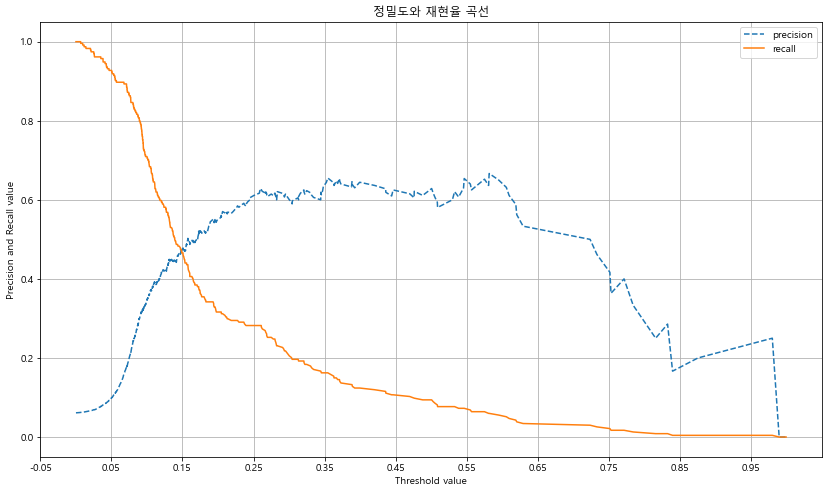

In [92]:
from sklearn.metrics import precision_recall_curve
import numpy as np

plt.rcParams["font.family"] = "Malgun Gothic"

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(14, 8))
    # 임곗값 수치    
    threshold_boundary = thresholds.shape[0]
    # 정밀도는 점선으로
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # 재현율은 선으로
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    # x축을 0.1씩 증가, 소수점 둘째자리까지 표시
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.title("정밀도와 재현율 곡선")
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_reg1.predict_proba(X_test)[:, 1])

# 임계값이 낮을수록 재현율은 높고, 정밀도는 낮다.
# 임계값이 클수록 재현율은 낮고, 정밀도는 높다.

## ROC_AUC

In [93]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률
pred_proba_class1 = lr_reg1.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# thresholds[0]은 max(예측확률)+1로 임의 설정. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0])

print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 2

In [94]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_reg1.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('AUC 값: {0:.4f}'.format(roc_score))

AUC 값: 0.8790


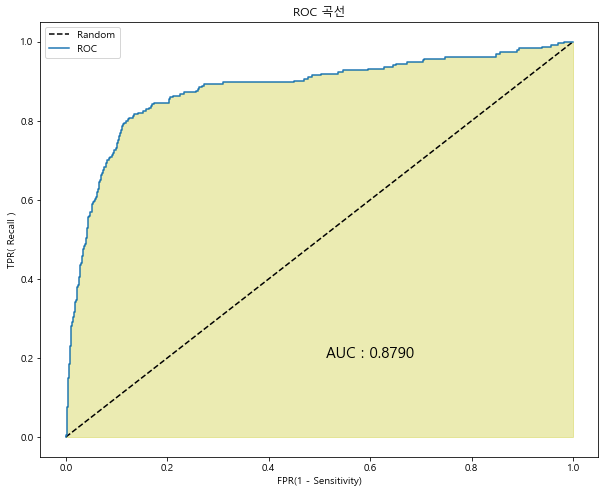

In [95]:
plt.figure(figsize=(10,8))

plt.title("ROC 곡선")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.plot(fprs, tprs, label="ROC")
plt.xlabel('FPR(1 - Sensitivity)')
plt.ylabel('TPR( Recall )')
plt.legend()
plt.fill_between(fprs, tprs, color='y', alpha=0.3)
plt.annotate('AUC : {0:.4f}'.format(roc_score), xy=(0.6, 0.2),ha='center', va='baseline', fontsize=15)
plt.show()

## Random Forest

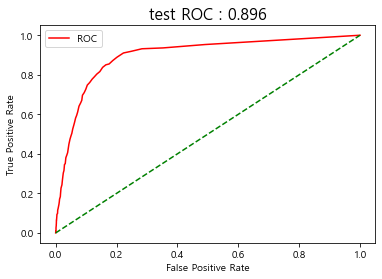

train_roc_auc score:  0.9990439770554493
test_roc_auc score:  0.5543487579570054 

train_f1 score:  0.999043062200957
test_f1 score:  0.18947368421052632 

train_recall score:  0.9980879541108987
test_recall score:  0.11538461538461539 

train_pre score:  1.0
test_pre score:  0.5294117647058824 

train acc score:  0.9998878923766816
test acc score:  0.939576249019095 



In [96]:
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
warnings.filterwarnings('ignore')

# DecisionTreeClassifier 학습/예측/평가
rf_clf_time = time.time()

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

trained_model = rf_clf.fit(X_train, y_train,)

train_pred = trained_model.predict(X_train)
train_prob = trained_model.predict_proba(X_train)[:, 1]

test_pred = trained_model.predict(X_test)
test_prob = trained_model.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, y_test, train_pred, test_pred, train_prob, test_prob)

## RF GridSearch CV

In [97]:
# RandomForestClassifier GridSearchCV
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[100],\
        'max_depth' : [8, 10, 12],\
        'min_samples_leaf' : [8, 10, 12, 16, 20],\
        'min_samples_split' : [4, 6, 8, 10]
        }

def best_rfparam(clf, param, scoring_name, cv_num):
        b_params= []

        grid_cv = GridSearchCV(clf, param_grid=param, scoring=scoring_name, cv=cv_num,)
        grid_cv.fit(X_train, y_train)

        b_params.append(grid_cv.best_params_)

        print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)
        print('\nGridSearchCV 최고 정확도 :{0:.4f}'.format(grid_cv.best_score_))
        best_est = grid_cv.best_estimator_

        # GridSearchCV의 최적 하이퍼 마라미터로 학습된 Estimator로 예측 및 평가 수행
        predictions = best_est.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

        return b_params

In [98]:
b_params = best_rfparam(rf_clf, parameters, 'accuracy', 5)
b_params[-1]

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 4, 'n_estimators': 100}

GridSearchCV 최고 정확도 :0.9415
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.9411


{'max_depth': 12,
 'min_samples_leaf': 20,
 'min_samples_split': 4,
 'n_estimators': 100}

In [99]:
# 최적 하이퍼 파라미터 저장

max_depth = 0
min_samples_leaf = 0
min_samples_split = 0
n_estimators = 0

for key, value in b_params[-1].items():
    if key == 'max_depth':
        max_depth = value
    if key == 'min_samples_leaf':
        min_samples_leaf = value
    elif key == 'min_samples_split':
        min_samples_split = value
    else:
        n_estimators = value

In [100]:
# 최적 하이퍼 파라미터 적용
rf_clf1 = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)
rf_clf1.fit(X_train, y_train)
rf1_pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, rf1_pred)))

예측 정확도: 0.9411


In [101]:
# 오차행렬, 정확도, 정밀도, 재현율, F1스코어 함수에 ROC_AUC 추가
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba) 
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [102]:
# 임곗값별 수치 함수 재설정
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, rf_clf1.predict_proba(X_test)[:, 1])

In [103]:
from sklearn.preprocessing import Binarizer

thresholds = [ 0.1, 0.2, 0.3,0.35]
pred_proba = rf_clf1.predict_proba(X_test)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.1
오차행렬
[[3103  486]
 [  39  195]]
정확도: 0.8627, 정밀도: 0.2863, 재현율: 0.8333, F1:0.4262, AUC:0.9119
임곗값: 0.2
오차행렬
[[3316  273]
 [  82  152]]
정확도: 0.9071, 정밀도: 0.3576, 재현율: 0.6496, F1:0.4613, AUC:0.9119
임곗값: 0.3
오차행렬
[[3454  135]
 [ 130  104]]
정확도: 0.9307, 정밀도: 0.4351, 재현율: 0.4444, F1:0.4397, AUC:0.9119
임곗값: 0.35
오차행렬
[[3512   77]
 [ 163   71]]
정확도: 0.9372, 정밀도: 0.4797, 재현율: 0.3034, F1:0.3717, AUC:0.9119


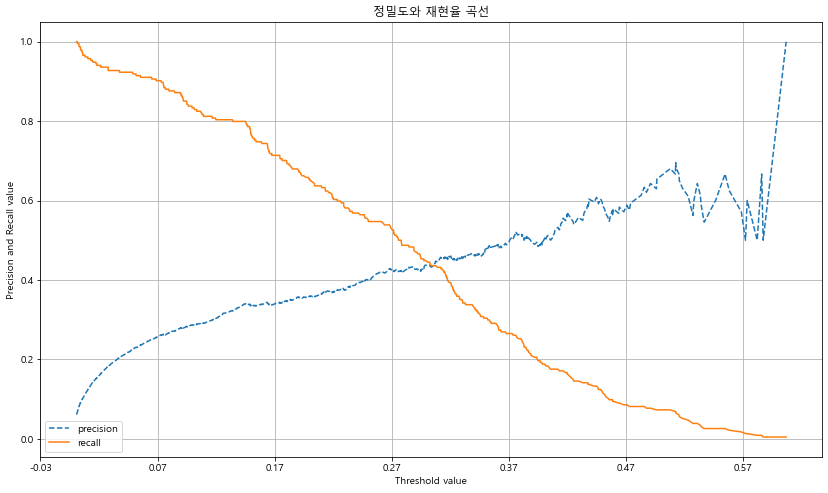

In [104]:
from sklearn.metrics import precision_recall_curve
import numpy as np

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(14, 8))
    # 임곗값 수치    
    threshold_boundary = thresholds.shape[0]
    # 정밀도는 점선으로
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # 재현율은 선으로
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    # x축을 0.1씩 증가, 소수점 둘째자리까지 표시
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.title("정밀도와 재현율 곡선")
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, rf_clf1.predict_proba(X_test)[:, 1])

# 임계값이 낮을수록 재현율은 높고, 정밀도는 낮다.
# 임계값이 클수록 재현율은 낮고, 정밀도는 높다.

## ROC_AUC

In [105]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률
pred_proba_class1 = rf_clf1.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# thresholds[0]은 max(예측확률)+1로 임의 설정. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0])

print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 2

In [106]:
from sklearn.metrics import roc_auc_score

pred_proba = rf_clf1.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('AUC 값: {0:.4f}'.format(roc_score))

AUC 값: 0.9119


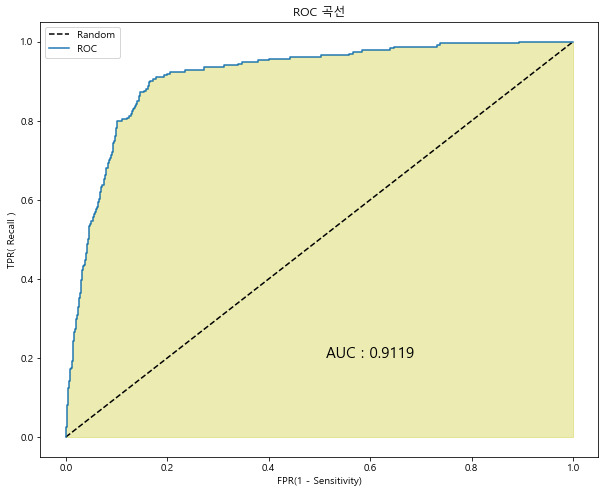

In [107]:
plt.figure(figsize=(10,8))

plt.title("ROC 곡선")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.plot(fprs, tprs, label="ROC")
plt.xlabel('FPR(1 - Sensitivity)')
plt.ylabel('TPR( Recall )')
plt.legend()
plt.fill_between(fprs, tprs, color='y', alpha=0.3)
plt.annotate('AUC : {0:.4f}'.format(roc_score), xy=(0.6, 0.2),ha='center', va='baseline', fontsize=15)
plt.show()